<a href="https://colab.research.google.com/github/CamiloVga/HarryPotterGPT/blob/main/HarryPotterGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
# 🧙‍♂️ HarryPotterGPT: Building a Language Model from Scratch

HarryPotterGPT is an educational implementation of a GPT-style language model trained on Harry Potter books.
Created by [Camilo Vega](https://www.linkedin.com/in/camilo-vega-169084b1/), AI Consultant and Professor.

## 📋 Features
- Custom tokenization with SentencePiece
- Decoder-only Transformer architecture
- Multi-format text processing (PDF, TXT, DOCX)
- Interactive interface with Gradio

## 🚀 Quick Guide
1. **Installation**: Run 'PHASE 0' section to install dependencies
2. **Data Preparation**: Place your Harry Potter books in the 'books/' folder
3. **Training**: Execute all script phases to process texts, train the tokenizer and model
4. **Generation**: Use the Gradio interface at the end to generate Harry Potter style text

## 📦 Pipeline Phases
- Phase 0-2: Installation and initial setup
- Phase 3: Text processing
- Phase 4: Tokenizer training
- Phase 5: Transformer configuration
- Phase 6: Model implementation and instantiation
- Phase 7: Model training
- Phase 8: Gradio user interface

For more details, visit the complete repository: https://github.com/CamiloVga/HarryPotterGPT
"""

#Phase 0-1: Setup & Dependencies
🔧 Initial configuration and installation of required libraries. Sets up PyTorch, SentencePiece tokenizer, text processing tools, and utilities. 📚 Imports essential modules for model building, data processing, and visualization. 🛠️ Configures reproducibility with seed setting and device detection for GPU/CPU selection.

In [1]:

# =============================================================================
# PHASE 0: DEPENDENCY INSTALLATION (RUN FIRST)
# =============================================================================
# Installation of basic libraries
!pip install torch numpy matplotlib pandas tqdm PyPDF2 nltk python-docx -q

# Specific installation for SentencePiece tokenizer
!pip install sentencepiece -q # Changed from tokenizers library to sentencepiece directly

# Installation for graphical interface
!pip install gradio -q

# Download necessary NLTK resources
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Downloading NLTK 'punkt' resource...")
    nltk.download('punkt', quiet=True)

# =============================================================================
# PHASE 1: LIBRARY IMPORTS
# =============================================================================

import os
import re
import random
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import unicodedata # For robust normalization
from pathlib import Path
import time # For timing and delays
import tempfile # For temporary files during tokenizer training
import traceback # For detailed error printing

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

# Processing
from tqdm.auto import tqdm
import PyPDF2
import docx # Requires python-docx
from nltk.tokenize import sent_tokenize # Primarily for informational display

# SentencePiece Tokenizer
try:
    import sentencepiece as spm
except ImportError:
    print("SentencePiece not found, attempting installation...")
    # Use pip install within the notebook/environment
    import sys
    # Uncomment the appropriate line for your environment:
    #!{sys.executable} -m pip install sentencepiece -q # For local environments/scripts
    get_ipython().system('pip install sentencepiece -q') # For Colab/Jupyter
    import sentencepiece as spm

# Gradio UI
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Phase 2: Book Downloading
📥 Automated acquisition of Harry Potter books from GitHub repository. 📁 Creates directory structure for storing corpus files. ✅ Verifies downloads with file size checking and fallback mechanisms. 🔄 Implements alternative download methods if primary approach fails, ensuring training data availability.

In [2]:
# =============================================================================
# PHASE 2: INITIAL CONFIGURATION AND BOOK DOWNLOADING
# =============================================================================

# Seed configuration for reproducibility
def set_seed(seed=42):
    """Set seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create folder for books
!mkdir -p books

# Download books from GitHub repository
def download_books_from_github():
    """
    Downloads Harry Potter books from the GitHub repository instead of
    requiring manual uploads.
    """
    print("\nDownloading Harry Potter books from GitHub repository...")

    # List of books to download with their URLs
    books_to_download = [
        {
            "url": "https://raw.githubusercontent.com/CamiloVga/HarryPotterGPT/main/HP_Book-Chamber-of-Secret.pdf",
            "filename": "books/HP_Book-Chamber-of-Secret.pdf"
        },
        {
            "url": "https://raw.githubusercontent.com/CamiloVga/HarryPotterGPT/main/HP_Book_Sorcerer's_Stone.pdf",
            "filename": "books/HP_Book_Sorcerer's_Stone.pdf"
        }
    ]

    # Download each book
    for book in books_to_download:
        try:
            print(f"  Downloading {book['filename']}...")
            # Escape single quote in filename for shell command
            escaped_filename = book['filename'].replace("'", "'\\''")
            !wget -q "{book['url']}" -O "{escaped_filename}"

            # Verify if the file was downloaded successfully
            if os.path.exists(book['filename']):
                file_size = os.path.getsize(book['filename'])
                print(f"  ✓ Successfully downloaded: {book['filename']} ({file_size/1024:.1f} KB)")
            else:
                print(f"  ✗ Failed to download: {book['filename']}")
        except Exception as e:
            print(f"  ✗ Error downloading {book['filename']}: {e}")

    # Check if any books were downloaded
    books_found = [f for f in os.listdir('books') if f.endswith(('.pdf', '.txt', '.docx'))]

    if books_found:
        print(f"\nSuccessfully downloaded {len(books_found)} books:")
        for i, book in enumerate(books_found, 1):
            print(f"  {i}. {book}")
    else:
        print("\n⚠️ No books were downloaded. Will try alternative method...")
        # Try alternative download method
        try:
            print("  Attempting to clone the entire repository...")
            !git clone --depth 1 https://github.com/CamiloVga/HarryPotterGPT.git temp_repo

            # Copy PDF files to books directory
            !cp temp_repo/*.pdf books/ 2>/dev/null || :

            # Clean up
            !rm -rf temp_repo

            # Check again
            books_found = [f for f in os.listdir('books') if f.endswith(('.pdf', '.txt', '.docx'))]
            if books_found:
                print(f"\nSuccessfully retrieved {len(books_found)} books using alternative method:")
                for i, book in enumerate(books_found, 1):
                    print(f"  {i}. {book}")
            else:
                print("\n❌ Failed to download books automatically.")
                print("Please upload Harry Potter book files (PDF, TXT, DOCX) to the 'books' directory manually.")
        except Exception as e:
            print(f"❌ Error with alternative download method: {e}")
            print("Please upload Harry Potter book files (PDF, TXT, DOCX) to the 'books' directory manually.")

    return books_found

# Execute the book downloading function
books_downloaded = download_books_from_github()

# Verify books are ready
if books_downloaded:
    print(f"\n✅ Books are ready for processing in Phase 3.")
else:
    print("\n⚠️ No books were found or downloaded.")
    print("Please ensure book files (PDF, TXT, DOCX) are available in the 'books' directory before proceeding to Phase 3.")

Using device: cuda

  ✓ Successfully downloaded: books/HP_Book-Chamber-of-Secret.pdf (2166.4 KB)
  ✗ Failed to download: books/HP_Book_Sorcerer's_Stone.pdf

Successfully downloaded 2 books:
  1. HP_Book_Sorcerer'\''s_Stone.pdf
  2. HP_Book-Chamber-of-Secret.pdf

✅ Books are ready for processing in Phase 3.


# Phase 3: Data Processing
📊 Transforms raw text from multiple formats (PDF, TXT, DOCX) into clean, consistent training corpus. 🧹 Applies text normalization with unicode standardization and whitespace management. 🧩 Adds document markers ([DOC_START], [DOC_END]) to maintain structural information. 📋 Generates metadata for corpus statistics.

In [3]:
# =============================================================================
# PHASE 3: DATA PROCESSING (Multilingual/Multi-format Ready)
# =============================================================================

class TextProcessor:
    """Class to process text files from multiple formats (PDF, TXT, DOCX)"""

    @staticmethod
    def extract_text_from_pdf(file_path):
        """Extract text from a PDF file"""
        text = ""
        try:
            with open(file_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                num_pages = len(pdf_reader.pages)
                for i, page in enumerate(pdf_reader.pages):
                    try:
                        page_text = page.extract_text()
                        if page_text:
                            # Normalize whitespace within the page text
                            page_text = ' '.join(page_text.split())
                            text += page_text + "\n" # Add newline after each page's content
                    except Exception as page_e:
                        print(f"  Warning: Could not extract text from page {i+1}/{num_pages} in {Path(file_path).name}: {page_e}")
                        continue # Skip problematic pages

            # Consolidate multiple newlines to paragraph breaks
            text = re.sub(r'\n{3,}', '\n\n', text)
            return text.strip()
        except Exception as e:
            print(f"Critical error processing PDF {file_path}: {e}")
            return ""

    @staticmethod
    def extract_text_from_txt(file_path, encoding='utf-8'):
        """Extract text from a TXT file, trying multiple encodings"""
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                return file.read()
        except UnicodeDecodeError:
            print(f"  Warning: UTF-8 decoding failed for {Path(file_path).name}. Trying latin-1...")
            try:
                with open(file_path, 'r', encoding='latin-1') as file:
                    return file.read()
            except Exception as e:
                print(f"Error processing TXT {file_path} with latin-1: {e}")
                return ""
        except Exception as e:
            print(f"Error processing TXT {file_path}: {e}")
            return ""

    @staticmethod
    def extract_text_from_docx(file_path):
        """Extract text from a DOCX file"""
        try:
            document = docx.Document(file_path)
            full_text = []
            for para in document.paragraphs:
                if para.text:
                    full_text.append(para.text)
            # Join paragraphs with double newline, mimicking paragraph structure
            return "\n\n".join(full_text).strip()
        except Exception as e:
            print(f"Error processing DOCX {file_path}: {e}")
            return ""

    @staticmethod
    def extract_text(file_path):
        """Extracts text from multiple file formats"""
        extension = Path(file_path).suffix.lower()

        if extension == '.pdf':
            return TextProcessor.extract_text_from_pdf(file_path)
        elif extension == '.txt':
            return TextProcessor.extract_text_from_txt(file_path)
        elif extension == '.docx':
            return TextProcessor.extract_text_from_docx(file_path)
        else:
            print(f"Unsupported format: {extension} - File: {file_path}")
            return ""

    @staticmethod
    def process_files(directory, extensions=None):
        """Processes all supported files in a directory"""
        if extensions is None:
            extensions = ['.pdf', '.txt', '.docx'] # Default supported extensions

        texts = []
        names = []
        metadata = []

        # List all files with supported extensions
        try:
            files_in_directory = os.listdir(directory)
        except FileNotFoundError:
            print(f"Error: Directory '{directory}' not found.")
            return [], [], []

        files = []
        for ext in extensions:
            files.extend([f for f in files_in_directory if f.lower().endswith(ext)])

        if not files:
            print(f"No files found with extensions {extensions} in '{directory}'")
            return [], [], []

        print(f"Found {len(files)} files:")
        for i, file in enumerate(files):
            print(f"  {i+1}. {file}")

        # Process each file
        print("\nProcessing files...")
        for file in tqdm(files, desc="Reading files"):
            full_path = os.path.join(directory, file)
            print(f"\nProcessing: {file}")
            text = TextProcessor.extract_text(full_path)

            if text and text.strip():
                # Perform initial normalization (Unicode NFC)
                text = unicodedata.normalize('NFC', text)
                texts.append(text)
                names.append(file)

                # Create metadata
                extension = Path(file).suffix.lower()
                try:
                    file_size = os.path.getsize(full_path)
                except OSError:
                    file_size = -1 # Indicate error getting size

                meta = {
                    "name": file,
                    "type": extension[1:],  # Remove leading dot
                    "raw_char_count": len(text),
                    "byte_size": file_size
                }
                metadata.append(meta)
                print(f"  ✓ {file}: {len(text):,} raw characters extracted")
            else:
                print(f"  ✗ Could not extract significant text from {file}")

        # Save metadata
        if metadata:
            metadata_path = 'corpus_metadata.json'
            try:
                with open(metadata_path, 'w', encoding='utf-8') as f:
                    json.dump(metadata, f, ensure_ascii=False, indent=2)
                print(f"\nMetadata saved to '{metadata_path}'")
            except IOError as e:
                print(f"Error saving metadata: {e}")

        return texts, names, metadata

    @staticmethod
    def clean_text(text):
        """
        General text cleaning and normalization for model training.
        Focuses on whitespace consistency and noise removal.
        """
        if not text:
            return ""

        # Remove non-printable control characters except newline and tab
        text = ''.join(c for c in text if c.isprintable() or c in ('\n', '\t'))

        # Normalize multiple spaces/newlines
        text = re.sub(r'[ \t]+', ' ', text)  # Replace multiple spaces/tabs with a single space
        text = re.sub(r'\n{3,}', '\n\n', text) # Collapse more than 2 newlines to 2 (paragraph break)
        text = text.replace('\r\n', '\n').replace('\r', '\n') # Normalize line breaks to \n

        # Add space around common punctuation to aid tokenization
        text = re.sub(r'([.,!?;:])([^\s.,!?;:])', r'\1 \2', text)

        # Remove leading/trailing whitespace from each line
        lines = text.split('\n')
        cleaned_lines = [line.strip() for line in lines]
        text = '\n'.join(cleaned_lines)

        # Remove multiple spaces that might have been reintroduced
        text = re.sub(r' {2,}', ' ', text)

        return text.strip() # Remove leading/trailing whitespace from the whole text

    @staticmethod
    def segment_into_sentences(text, language='english'):
        """Splits text into sentences using NLTK (language-aware)"""
        try:
            # Map simple language names to NLTK's expected format if necessary
            lang_map = {'spanish': 'spanish', 'english': 'english'} # Add more if needed
            nltk_lang = lang_map.get(language.lower(), 'english') # Default to english if unknown
            return sent_tokenize(text, language=nltk_lang)
        except LookupError:
            print(f"Warning: NLTK 'punkt' resource for language '{language}' not found. Using simple split.")
            # Simple fallback if NLTK fails or language is unavailable
            return re.split(r'(?<=[.!?])\s+', text)
        except Exception as e:
            print(f"Unexpected error in sentence segmentation: {e}")
            return [text] # Return the whole text as one sentence in case of error

    @staticmethod
    def mark_documents(texts, names):
        """Adds special markers for the start and end of each document"""
        marked_texts = []
        if not texts:
            return []

        for i, (text, name) in enumerate(zip(texts, names)):
            # Document markers for tracking document boundaries
            doc_start_marker = f"[DOC_START:{i}]"
            doc_end_marker = f"[DOC_END:{i}]"

            # Ensure markers are on their own lines and separated from text
            marked_text = f"{doc_start_marker}\n\n{text}\n\n{doc_end_marker}"
            marked_texts.append(marked_text)

        return marked_texts

# Function to execute Phase 3
def run_data_processing(directory='books', extensions=None):
    """Runs the data processing pipeline"""
    print("\n" + "="*60)
    print("PHASE 3: DATA PROCESSING (PDF, TXT, DOCX)")
    print("="*60)

    if extensions is None:
        extensions = ['.pdf', '.txt', '.docx']

    # Process files
    print(f"\nLoading files from '{directory}'...")
    raw_texts, names, metadata = TextProcessor.process_files(directory, extensions)

    if not raw_texts:
        print(f"\nNo texts loaded. Please add files (PDF, TXT, DOCX) to the '{directory}' folder.")
        return None, None, None

    # Preprocess texts (general cleaning)
    print("\nCleaning texts...")
    cleaned_texts = []
    original_indices = list(range(len(raw_texts))) # Keep track of original indices for metadata update
    indices_to_keep = []

    for i, text in enumerate(tqdm(raw_texts, desc="Cleaning texts")):
        clean = TextProcessor.clean_text(text)
        if clean:
            cleaned_texts.append(clean)
            indices_to_keep.append(original_indices[i])
            # Update metadata with cleaned character count later
        else:
            print(f"  Warning: Text from '{names[original_indices[i]]}' became empty after cleaning.")

    # Filter names and metadata based on texts that remained
    final_names = [names[i] for i in indices_to_keep]
    final_metadata = [metadata[i] for i in indices_to_keep]

    # Update metadata with cleaned counts
    for i, text in enumerate(cleaned_texts):
        if i < len(final_metadata):
            final_metadata[i]["cleaned_char_count"] = len(text)

    if not cleaned_texts:
        print("\nNo valid texts remained after cleaning.")
        return None, None, None

    # Show details of loaded and cleaned texts
    print("\nProcessed and cleaned documents:")
    total_cleaned_chars = 0
    for i, (name, text, meta) in enumerate(zip(final_names, cleaned_texts, final_metadata)):
        num_paras = text.count('\n\n') + 1
        cleaned_chars = len(text)
        total_cleaned_chars += cleaned_chars
        print(f"  {i+1}. {name}: {cleaned_chars:,} cleaned characters, ~{num_paras} paragraphs.")

    print(f"\nTotal cleaned characters: {total_cleaned_chars:,}")

    # Add document markers
    print("\nAdding document markers ([DOC_START:id], [DOC_END:id])...")
    marked_texts = TextProcessor.mark_documents(cleaned_texts, final_names)

    # Join all marked texts into one for the tokenizer
    full_marked_text = "\n\n".join(marked_texts)
    print(f"\nFull marked text size: {len(full_marked_text):,} characters")

    # Save full processed and marked text for the tokenizer
    processed_text_path = 'corpus_full_processed.txt'
    try:
        with open(processed_text_path, 'w', encoding='utf-8') as f:
            f.write(full_marked_text)
        print(f"\nFull processed and marked text saved to '{processed_text_path}'")
    except IOError as e:
         print(f"Error saving the full corpus: {e}")

    # Save each cleaned document separately for reference
    output_processed_dir = 'texts_processed_individual'
    try:
        os.makedirs(output_processed_dir, exist_ok=True)
        print(f"\nSaving individual cleaned documents to '{output_processed_dir}'...")
        for i, (text, name) in enumerate(zip(cleaned_texts, final_names)):
            base_name = Path(name).stem
            try:
                with open(os.path.join(output_processed_dir, f'{base_name}_clean.txt'), 'w', encoding='utf-8') as f:
                    f.write(text)
            except IOError as e:
                print(f"  Error saving {base_name}_clean.txt: {e}")
        print("Individual documents saved.")
    except OSError as e:
        print(f"Error creating directory '{output_processed_dir}': {e}")

    print("\n" + "="*60)
    print("DATA PROCESSING COMPLETE")
    print("="*60)

    # Return cleaned texts (without markers), the combined marked text, and final metadata
    return cleaned_texts, full_marked_text, final_metadata

# --- EXECUTE PHASE 3 ---
# Make sure book files are in the 'books' directory before running this
cleaned_texts_p3, corpus_for_tokenizer_p3, metadata_p3 = run_data_processing(directory='books')


PHASE 3: DATA PROCESSING (PDF, TXT, DOCX)

Loading files from 'books'...
Found 2 files:
  1. HP_Book_Sorcerer'\''s_Stone.pdf
  2. HP_Book-Chamber-of-Secret.pdf

Processing files...


Reading files:   0%|          | 0/2 [00:00<?, ?it/s]


Processing: HP_Book_Sorcerer'\''s_Stone.pdf
  ✓ HP_Book_Sorcerer'\''s_Stone.pdf: 435,065 raw characters extracted

Processing: HP_Book-Chamber-of-Secret.pdf
  ✓ HP_Book-Chamber-of-Secret.pdf: 732,174 raw characters extracted

Metadata saved to 'corpus_metadata.json'

Cleaning texts...


Cleaning texts:   0%|          | 0/2 [00:00<?, ?it/s]


Processed and cleaned documents:
  1. HP_Book_Sorcerer'\''s_Stone.pdf: 437,718 cleaned characters, ~1 paragraphs.
  2. HP_Book-Chamber-of-Secret.pdf: 733,800 cleaned characters, ~1 paragraphs.

Total cleaned characters: 1,171,518

Adding document markers ([DOC_START:id], [DOC_END:id])...

Full marked text size: 1,171,576 characters

Full processed and marked text saved to 'corpus_full_processed.txt'

Saving individual cleaned documents to 'texts_processed_individual'...
Individual documents saved.

DATA PROCESSING COMPLETE


# Phase 4: Tokenizer Training
🔤 Builds custom SentencePiece tokenizer optimized for narrative text. 🏷️ Handles special tokens for model control ([PAD], [UNK], [BOS], [EOS]). 📏 Implements dynamic vocabulary sizing with automatic retry mechanism. 💾 Tokenizes and saves corpus as numerical token IDs for efficient training.

In [4]:
# =============================================================================
# PHASE 4: SENTENCEPIECE TOKENIZER (with Vocab Size Retry)
# =============================================================================

class EnhancedSentencePieceTokenizer:
    """
    Implementation of SentencePiece tokenizer with robust handling
    of special tokens and improved space processing for narrative texts.
    """
    def __init__(self,
                vocab_size=8000,
                model_type="unigram",
                character_coverage=0.9999,
                model_prefix="spm_tokenizer"):

        self.initial_vocab_size = vocab_size
        self.vocab_size = vocab_size
        self.model_type = model_type
        self.character_coverage = character_coverage
        self.model_prefix = model_prefix

        # Special tokens
        self.special_tokens = {
            "pad_token": "[PAD]",  # ID 0
            "unk_token": "[UNK]",  # ID 1
            "bos_token": "[BOS]",  # ID 2
            "eos_token": "[EOS]",  # ID 3
        }

        # Document structure tokens
        self.structural_tokens = [
            "[DOC_START:",
            "[DOC_END:"
        ]
        # Generate specific tokens for each numbered document
        max_docs = 100
        self.structural_tokens.extend([f"[DOC_START:{i}]" for i in range(max_docs)])
        self.structural_tokens.extend([f"[DOC_END:{i}]" for i in range(max_docs)])
        self.structural_tokens = sorted(list(set(self.structural_tokens)))

        # Combine all tokens for SentencePiece
        self.user_defined_symbols_list = (
            list(self.special_tokens.values()) +
            self.structural_tokens
        )

        # Instance properties
        self.sp_model = None
        self.model_path = None
        self.vocab_path = None
        self.info_path = None
        self.special_token_ids = {}

    def _normalize_text(self, text):
        """Robust text normalization for consistent processing."""
        if not isinstance(text, str):
            try:
                text = text.decode('utf-8')
            except:
                print(f"Warning: Could not decode text to UTF-8.")
                return ""
        # NFC normalization with specific handling for narrative
        normalized = unicodedata.normalize('NFC', text)

        # Additional normalization for better consistency
        normalized = re.sub(r'…', '...', normalized)  # Normalize ellipsis
        normalized = re.sub(r'[´`\']', "'", normalized)  # Normalize apostrophes
        normalized = re.sub(r'["""]', '"', normalized)  # Normalize quotes

        return normalized

    def train(self, text_corpus, output_prefix=None, max_retries=5, retry_delay=2):
        """
        Trains a new SentencePiece tokenizer with robust error handling
        and automatic retry to optimize vocabulary size.
        """
        if output_prefix is None:
            output_prefix = self.model_prefix

        output_dir = os.path.dirname(output_prefix)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"Created directory: {output_dir}")

        # Prepare corpus content
        if isinstance(text_corpus, list):
            corpus_content = "\n".join(self._normalize_text(text) for text in text_corpus if text)
        elif isinstance(text_corpus, str):
            corpus_content = self._normalize_text(text_corpus)
        else:
            print("Error: text_corpus must be a string or list of strings.")
            return None

        if not corpus_content.strip():
            print("Error: Corpus content is empty after normalization.")
            return None

        corpus_file_path = None
        current_vocab_size = self.initial_vocab_size
        success = False

        try:
            # Write corpus to temporary file
            with tempfile.NamedTemporaryFile(mode='w', encoding='utf-8', delete=False, suffix='.txt') as f:
                f.write(corpus_content)
                corpus_file_path = f.name
            print(f"Temporary corpus created at: {corpus_file_path}")

            for attempt in range(max_retries):
                print(f"\n--- Training Attempt {attempt + 1}/{max_retries} (Vocab Size: {current_vocab_size}) ---")

                # Prepare arguments for SentencePiece Trainer
                user_symbols = ','.join(self.user_defined_symbols_list)
                pad_id = 0
                unk_id = 1
                bos_id = 2
                eos_id = 3

                # Optimized configuration for narratives
                train_command_list = [
                    f"--input={corpus_file_path}",
                    f"--model_prefix={output_prefix}",
                    f"--vocab_size={current_vocab_size}",
                    f"--model_type={self.model_type}",
                    f"--character_coverage={self.character_coverage}",
                    f"--pad_id={pad_id}",
                    f"--unk_id={unk_id}",
                    f"--bos_id={bos_id}",
                    f"--eos_id={eos_id}",
                    f"--user_defined_symbols={user_symbols}",
                    f"--split_by_whitespace=true",
                    f"--split_by_number=true",
                    f"--split_by_unicode_script=true",
                    f"--normalization_rule_name=nmt_nfkc_cf",
                    f"--add_dummy_prefix=true",
                    f"--remove_extra_whitespaces=true",
                    f"--treat_whitespace_as_suffix=false",
                    f"--hard_vocab_limit=false",
                    f"--input_sentence_size=10000000",
                    f"--shuffle_input_sentence=true"
                ]
                train_command = " ".join(train_command_list)

                try:
                    # Train the model
                    spm.SentencePieceTrainer.train(train_command)
                    print(f"Training successful on attempt {attempt + 1} with vocab_size = {current_vocab_size}")
                    success = True
                    self.vocab_size = current_vocab_size
                    break

                except RuntimeError as e:
                    error_msg = str(e)
                    print(f"Error on attempt {attempt + 1}: {error_msg}")

                    # Check if it's a vocabulary size error
                    if "Vocabulary size is larger than the number of unique" in error_msg or \
                       "too high" in error_msg.lower():
                        # Try to parse the suggested maximum size
                        match = re.search(r'<= (\d+)', error_msg)
                        if match:
                            max_suggested = int(match.group(1))
                            new_vocab_size = max(len(self.user_defined_symbols_list) + 100,
                                               int(max_suggested * 0.95))
                            print(f"Reducing vocabulary size based on suggestion ({max_suggested}) to ~{new_vocab_size}")
                        else:
                            new_vocab_size = max(len(self.user_defined_symbols_list) + 100,
                                              int(current_vocab_size * 0.8))
                            print(f"Could not parse suggested size. Reducing vocabulary to ~{new_vocab_size}")

                        if new_vocab_size >= current_vocab_size:
                            new_vocab_size = max(len(self.user_defined_symbols_list) + 100, int(current_vocab_size * 0.8))
                            print(f"Further reducing vocabulary size to ~{new_vocab_size}")

                        current_vocab_size = new_vocab_size

                        if attempt < max_retries - 1:
                            print(f"Waiting {retry_delay}s before retrying...")
                            time.sleep(retry_delay)
                        else:
                            print("Maximum retries reached due to vocabulary size error.")
                    else:
                        print("Runtime error not related to vocabulary size. Will not retry.")
                        raise e

                except Exception as e:
                    print(f"Unexpected error during training attempt {attempt+1}: {e}")
                    raise e

            # Check training success
            if not success:
                print(f"\nSentencePiece training failed after {max_retries} attempts.")
                return None

            # Post-successful training steps
            self.model_path = f"{output_prefix}.model"
            self.vocab_path = f"{output_prefix}.vocab"
            self.info_path = f"{output_prefix}_info.json"

            # Load the trained model
            self.sp_model = spm.SentencePieceProcessor()
            self.sp_model.load(self.model_path)
            print(f"SentencePiece model loaded from: {self.model_path}")

            # Verify vocabulary size
            loaded_vocab_size = self.sp_model.get_piece_size()
            if loaded_vocab_size != self.vocab_size:
                print(f"Warning: Final vocab size ({self.vocab_size}) differs from loaded model ({loaded_vocab_size}). Using loaded size.")
                self.vocab_size = loaded_vocab_size
            print(f"Actual vocabulary size: {self.vocab_size}")

            # Verify special token IDs
            self.special_token_ids = {
                name: self.sp_model.piece_to_id(token)
                for name, token in self.special_tokens.items()
            }

            # Check for unknown special tokens
            unknown_specials = {name: token for name, token in self.special_tokens.items()
                              if self.special_token_ids[name] == self.sp_model.unk_id()}
            if unknown_specials:
                print(f"Warning: Some special tokens were not found in the vocabulary and map to UNK: {unknown_specials}")
            print(f"Verified special token IDs: {self.special_token_ids}")

            # Save tokenizer information
            tokenizer_info = {
                "vocab_size": self.vocab_size,
                "initial_vocab_size_requested": self.initial_vocab_size,
                "model_type": self.model_type,
                "character_coverage": self.character_coverage,
                "model_prefix": output_prefix,
                "model_path": self.model_path,
                "vocab_path": self.vocab_path,
                "info_path": self.info_path,
                "special_tokens": self.special_tokens,
                "special_token_ids": self.special_token_ids,
                "structural_tokens": self.structural_tokens,
                "user_defined_symbols_list": self.user_defined_symbols_list
            }
            try:
                with open(self.info_path, 'w', encoding='utf-8') as f:
                    json.dump(tokenizer_info, f, ensure_ascii=False, indent=2)
                print(f"Tokenizer information saved to: {self.info_path}")
            except IOError as e:
                print(f"Error saving tokenizer info: {e}")

            return self

        except Exception as e:
            print(f"\nGeneral error during SentencePiece preparation or training loop: {e}")
            traceback.print_exc()
            return None
        finally:
            # Clean up temporary file
            if corpus_file_path and os.path.exists(corpus_file_path):
                try:
                    os.unlink(corpus_file_path)
                except OSError as unlink_e:
                    print(f"Error deleting temporary file: {unlink_e}")

    def load(self, model_prefix_or_path):
        """
        Loads a pre-trained SentencePiece model and its configuration,
        with robust error handling and information recovery.
        """
        if model_prefix_or_path.endswith(".model"):
            self.model_path = model_prefix_or_path
            self.model_prefix = model_prefix_or_path[:-len(".model")]
        else:
            self.model_prefix = model_prefix_or_path
            self.model_path = f"{self.model_prefix}.model"

        self.vocab_path = f"{self.model_prefix}.vocab"
        self.info_path = f"{self.model_prefix}_info.json"

        if not os.path.exists(self.model_path):
            raise FileNotFoundError(f"SentencePiece model not found at: {self.model_path}")

        # Load the SentencePiece processor
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.load(self.model_path)
        self.vocab_size = self.sp_model.get_piece_size()

        print(f"SentencePiece model loaded from: {self.model_path}")
        print(f"Vocabulary size: {self.vocab_size} tokens")

        # Load information file if it exists
        if os.path.exists(self.info_path):
            try:
                with open(self.info_path, 'r', encoding='utf-8') as f:
                    tokenizer_info = json.load(f)
                # Restore key attributes
                self.model_type = tokenizer_info.get('model_type', self.model_type)
                self.character_coverage = tokenizer_info.get('character_coverage', self.character_coverage)
                self.special_tokens = tokenizer_info.get('special_tokens', self.special_tokens)
                self.special_token_ids = tokenizer_info.get('special_token_ids', {})
                self.structural_tokens = tokenizer_info.get('structural_tokens', [])
                self.initial_vocab_size = tokenizer_info.get('initial_vocab_size_requested', self.vocab_size)
                self.user_defined_symbols_list = tokenizer_info.get('user_defined_symbols_list', [])
                print(f"Tokenizer information loaded from: {self.info_path}")
                if not self.special_token_ids:
                    print("Warning: Special token IDs not found in info file, attempting to infer...")
                    self._infer_special_token_ids()
                print(f"Recovered/Inferred special token IDs: {self.special_token_ids}")
            except Exception as e:
                print(f"Warning: Could not load or parse info file '{self.info_path}': {e}")
                self._infer_special_token_ids()
        else:
            print(f"Warning: Information file not found at '{self.info_path}'. Inferring special token IDs.")
            self._infer_special_token_ids()

        # Ensure vocab_size matches the loaded model
        if self.sp_model:
            self.vocab_size = self.sp_model.get_piece_size()
        else:
            print("Error: sp_model is None after attempting load.")

        return self

    def _infer_special_token_ids(self):
        """Helper function to infer special token IDs from loaded SP model."""
        if not self.sp_model:
            print("Error: Cannot infer IDs, SentencePiece model not loaded.")
            self.special_token_ids = {}
            return

        # Assign IDs to special tokens
        self.special_token_ids = {
            name: self.sp_model.piece_to_id(token)
            for name, token in self.special_tokens.items()
        }
        print(f"Inferred special token IDs from model: {self.special_token_ids}")

    def encode(self, text, add_bos=False, add_eos=False, max_length=None, truncation=True):
        """
        Encodes text into a list of token IDs with handling
        of special tokens and length control.
        """
        if not self.sp_model:
            raise ValueError("SentencePiece model not loaded. Call train() or load() first.")

        normalized_text = self._normalize_text(text)

        # Use encode_as_ids for direct ID output
        ids = self.sp_model.encode_as_ids(normalized_text)

        # Add special tokens if requested
        bos_id = self.special_token_ids.get('bos_token', self.unk_id)
        eos_id = self.special_token_ids.get('eos_token', self.unk_id)

        if add_bos and self.sp_model.id_to_piece(bos_id) != "[UNK]":
            ids = [bos_id] + ids
        if add_eos and self.sp_model.id_to_piece(eos_id) != "[UNK]":
            ids = ids + [eos_id]

        # Apply truncation if max_length is set
        if max_length is not None and truncation and len(ids) > max_length:
            if add_eos and self.sp_model.id_to_piece(eos_id) != "[UNK]" and ids[-1] == eos_id:
                ids = ids[:max_length-1] + [eos_id]
            else:
                ids = ids[:max_length]

        return ids

    def decode(self, ids, skip_special_tokens=True):
        """
        Decodes a list of token IDs back to text with improved
        handling of special tokens for better coherence.
        """
        if not self.sp_model:
            raise ValueError("SentencePiece model not loaded.")

        if isinstance(ids, torch.Tensor):
            ids = ids.tolist()

        # Filter valid IDs
        valid_ids = [i for i in ids if 0 <= i < self.vocab_size]

        # Filter special tokens if requested
        if skip_special_tokens:
            # Gather all special token IDs to filter
            special_ids_to_skip = set(self.special_token_ids.values())

            # Add default SentencePiece special IDs
            special_ids_to_skip.add(self.sp_model.pad_id())
            special_ids_to_skip.add(self.sp_model.unk_id())
            special_ids_to_skip.add(self.sp_model.bos_id())
            special_ids_to_skip.add(self.sp_model.eos_id())

            # Filter document control tokens
            doc_control_tokens = []
            for i in valid_ids:
                piece = self.sp_model.id_to_piece(i)
                if '[DOC_START' in piece or '[DOC_END' in piece:
                    doc_control_tokens.append(i)

            # Combine all tokens to filter
            all_to_skip = special_ids_to_skip.union(set(doc_control_tokens))

            # Apply filter
            valid_ids = [token_id for token_id in valid_ids if token_id not in all_to_skip]

        # Use decode method that correctly handles joining pieces
        decoded_text = self.sp_model.decode(valid_ids)

        # Final normalization
        decoded_text = unicodedata.normalize('NFC', decoded_text)

        # Additional cleaning for better coherence
        decoded_text = re.sub(r'\s{2,}', ' ', decoded_text)
        decoded_text = re.sub(r'(\w)[,.](\w)', r'\1, \2', decoded_text)

        return decoded_text

    def tokenize(self, text):
        """Splits text into SentencePiece pieces (tokens as strings)."""
        if not self.sp_model:
            raise ValueError("SentencePiece model not loaded.")

        normalized_text = self._normalize_text(text)
        return self.sp_model.encode_as_pieces(normalized_text)

    def convert_tokens_to_ids(self, tokens):
        """Converts a list of pieces (tokens) to IDs."""
        if not self.sp_model:
            raise ValueError("SentencePiece model not loaded.")

        return [self.sp_model.piece_to_id(token) for token in tokens]

    def convert_ids_to_tokens(self, ids):
        """Converts a list of IDs to pieces (tokens)."""
        if not self.sp_model:
            raise ValueError("SentencePiece model not loaded.")

        if isinstance(ids, torch.Tensor):
            ids = ids.tolist()

        vocab_s = self.sp_model.get_piece_size() if self.sp_model else 0
        return [self.sp_model.id_to_piece(id) if 0 <= id < vocab_s else '[INVALID_ID]' for id in ids]

    def get_vocab(self):
        """Returns the vocabulary as a dictionary {token: id}."""
        if not self.sp_model:
            raise ValueError("SentencePiece model not loaded.")

        vocab_s = self.sp_model.get_piece_size()
        return {self.sp_model.id_to_piece(i): i for i in range(vocab_s)}

    # Properties to consistently access special token IDs
    @property
    def pad_id(self): return self.special_token_ids.get('pad_token', 0)
    @property
    def unk_id(self): return self.special_token_ids.get('unk_token', 1)
    @property
    def bos_id(self): return self.special_token_ids.get('bos_token', 2)
    @property
    def eos_id(self): return self.special_token_ids.get('eos_token', 3)

# Execute tokenizer training
TOKENIZER_PREFIX_P4 = "spm_harry_potter"
print(f"\nTraining SentencePiece tokenizer with prefix: {TOKENIZER_PREFIX_P4}")

# Ensure we have the corpus from Phase 3
if 'corpus_for_tokenizer_p3' not in locals():
    print("Error: No corpus found from Phase 3. Please run Phase 3 first.")
else:
    tokenizer = EnhancedSentencePieceTokenizer(
        vocab_size=8000,
        model_type="unigram",
        character_coverage=0.9999,
        model_prefix=TOKENIZER_PREFIX_P4
    )

    trained_tokenizer = tokenizer.train(corpus_for_tokenizer_p3)

    if trained_tokenizer:
        print("\nTokenizer training successful! Files created:")
        print(f"- {TOKENIZER_PREFIX_P4}.model (tokenizer model)")
        print(f"- {TOKENIZER_PREFIX_P4}.vocab (vocabulary)")
        print(f"- {TOKENIZER_PREFIX_P4}_info.json (configuration)")
    else:
        print("\nTokenizer training failed. Check error messages above.")


# Generar y guardar tokens pre-procesados para entrenamiento
print("\nGenerando archivo de tokens para entrenamiento...")
if 'corpus_for_tokenizer_p3' in locals() and trained_tokenizer:
    # Tokenizar todo el corpus
    all_token_ids = trained_tokenizer.encode(corpus_for_tokenizer_p3, add_bos=False, add_eos=False)

    # Guardar los IDs de tokens en un archivo JSON
    tokens_file_path = f"{TOKENIZER_PREFIX_P4}_all_token_ids.json"
    with open(tokens_file_path, 'w') as f:
        json.dump(all_token_ids, f)

    print(f"✓ {len(all_token_ids):,} tokens guardados en '{tokens_file_path}'")
    print(f"  Este archivo será utilizado en la Fase 7 para el entrenamiento del modelo.")
else:
    print("✗ No se pudo generar el archivo de tokens. Falta el corpus o el tokenizer.")


Training SentencePiece tokenizer with prefix: spm_harry_potter
Temporary corpus created at: /tmp/tmpj8maff_2.txt

--- Training Attempt 1/5 (Vocab Size: 8000) ---
Training successful on attempt 1 with vocab_size = 8000
SentencePiece model loaded from: spm_harry_potter.model
Actual vocabulary size: 6450
Verified special token IDs: {'pad_token': 4, 'unk_token': 5, 'bos_token': 6, 'eos_token': 7}
Tokenizer information saved to: spm_harry_potter_info.json

Tokenizer training successful! Files created:
- spm_harry_potter.model (tokenizer model)
- spm_harry_potter.vocab (vocabulary)
- spm_harry_potter_info.json (configuration)

Generando archivo de tokens para entrenamiento...
✓ 446,277 tokens guardados en 'spm_harry_potter_all_token_ids.json'
  Este archivo será utilizado en la Fase 7 para el entrenamiento del modelo.


# Phase 5: Transformer Configuration
⚙️ Defines model architecture with scalable configurations (small/medium/large). 📊 Calculates parameter counts and memory requirements. 🧠 Optimizes hyperparameters for narrative text generation. 📈 Visualizes architecture details with comprehensive component breakdown. 🔄 Ensures compatibility between tokenizer and model settings.

In [21]:
# =============================================================================
# PHASE 5: TRANSFORMER CONFIGURATION
# =============================================================================

class EnhancedTransformerConfig:
    """
    Enhanced Transformer configuration optimized for narrative text generation
    with balanced parameters for performance and resource usage.
    """
    def __init__(
        self,
        # Model architecture parameters
        vocab_size=10000,            # Size of the vocabulary (number of unique tokens)
        context_length=768,          # Maximum sequence length the model can process
        embed_dim=512,               # Dimension of token embeddings
        num_heads=8,                 # Number of attention heads for multi-head attention
        ff_dim=2048,                 # Feed-forward network hidden dimension (4x embed_dim)
        num_layers=8,                # Number of transformer layers/blocks in the model
        dropout=0.15,                # General dropout rate for regularization
        attention_dropout=0.15,      # Specific dropout rate for attention weights
        embedding_dropout=0.1,       # Dropout rate applied to the embeddings
        use_pre_layer_norm=True,     # Apply layer norm before attention (True) or after (False)
        layer_norm_epsilon=1e-5,     # Small constant added for numerical stability in layer norm

        # Training parameters
        batch_size=8,                # Number of sequences processed in parallel
        learning_rate=5e-5,          # Base learning rate for optimizer
        weight_decay=0.01,           # L2 regularization strength
        num_epochs=15,               # Total training iterations over the entire dataset
        warmup_ratio=0.1,            # Portion of training steps for learning rate warmup
        final_lr_ratio=0.05,         # Final learning rate as a fraction of initial rate
        gradient_clip_val=1.0,       # Maximum gradient norm for gradient clipping
    ):
        # Model architecture parameters
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        self.embedding_dropout = embedding_dropout
        self.use_pre_layer_norm = use_pre_layer_norm
        self.layer_norm_epsilon = layer_norm_epsilon

        # Training parameters
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.warmup_ratio = warmup_ratio
        self.final_lr_ratio = final_lr_ratio
        self.gradient_clip_val = gradient_clip_val

        # Default padding token ID, will be updated from the loaded tokenizer
        self.pad_token_id = 0

        # Ensure embed_dim is divisible by num_heads
        if embed_dim > 0 and num_heads > 0 and embed_dim % num_heads != 0:
             # Find the largest valid number of heads <= requested number
             valid_heads = [h for h in range(num_heads, 0, -1) if embed_dim % h == 0]
             suggested_heads = valid_heads[0] if valid_heads else 1
             print(f"Warning: embed_dim ({embed_dim}) is not divisible by num_heads ({num_heads}).")
             print(f"Changing num_heads to {suggested_heads} to ensure divisibility.")
             self.num_heads = suggested_heads
        elif embed_dim <= 0 or num_heads <= 0:
             print("Warning: embed_dim or num_heads is not positive. Setting num_heads to 1.")
             self.num_heads = 1
        else:
            self.num_heads = num_heads

    def __str__(self):
        """String representation of the configuration"""
        config_str = f"EnhancedTransformerConfig(\n"
        for key, value in self.__dict__.items():
             # Format learning rate nicely
             if key == 'learning_rate':
                 config_str += f"  {key}: {value:.1e}\n"
             else:
                 config_str += f"  {key}: {value}\n"
        config_str += f")"
        return config_str

    def to_dict(self):
        """Convert configuration to a dictionary"""
        return self.__dict__.copy()

    @classmethod
    def from_dict(cls, config_dict):
        """Create configuration instance from a dictionary"""
        # Create default instance
        instance = cls()
        # Update attributes from the dictionary
        instance.__dict__.update(config_dict)
        # Re-validate head divisibility after loading
        if hasattr(instance, 'embed_dim') and hasattr(instance, 'num_heads'):
             if instance.embed_dim > 0 and instance.num_heads > 0 and instance.embed_dim % instance.num_heads != 0:
                  print(f"Warning (from_dict): Loaded embed_dim ({instance.embed_dim}) not divisible by num_heads ({instance.num_heads}).")
                  # Adjust heads if needed
                  valid_heads = [h for h in range(instance.num_heads, 0, -1) if instance.embed_dim % h == 0]
                  instance.num_heads = valid_heads[0] if valid_heads else 1
                  print(f"Adjusted num_heads to {instance.num_heads}")
        return instance

    def get_small_config(self):
        """Returns a small model configuration for faster training or limited resources"""
        small_config = self.to_dict()
        small_config.update({
            "context_length": 512,      # Shorter context window
            "embed_dim": 256,           # Smaller embedding dimension
            "num_heads": 4,             # Fewer attention heads
            "ff_dim": 1024,             # Smaller feed-forward dimension
            "num_layers": 4,            # Fewer transformer layers
            "batch_size": 8,            # Smaller batch size
            "num_epochs": 20            # More epochs for smaller models
        })
        return self.__class__.from_dict(small_config)

    def get_medium_config(self):
        """Returns a medium-sized model configuration"""
        medium_config = self.to_dict()
        medium_config.update({
            "context_length": 512,      # Moderate context window
            "embed_dim": 384,           # Medium embedding dimension
            "num_heads": 6,             # Medium number of heads
            "ff_dim": 1536,             # Medium feed-forward dimension
            "num_layers": 6,            # Medium number of layers
            "batch_size": 16,           # Medium batch size
            "num_epochs": 15            # Default epochs
        })
        return self.__class__.from_dict(medium_config)

    def get_large_config(self):
        """Returns a larger model configuration for better performance"""
        large_config = self.to_dict()
        large_config.update({
            "context_length": 1024,     # Larger context window
            "embed_dim": 768,           # Larger embedding dimension
            "num_heads": 12,            # More attention heads
            "ff_dim": 3072,             # Larger feed-forward dimension
            "num_layers": 12,           # More transformer layers
            "batch_size": 32,           # Larger batch size
            "dropout": 0.1,             # Slightly lower dropout for larger models
            "num_epochs": 10            # Fewer epochs for larger models
        })
        return self.__class__.from_dict(large_config)


# --- Function to Visualize Transformer Architecture ---
def visualize_transformer_architecture(config):
    """Prints a visualization of the Transformer architecture based on the config"""
    print("\n" + "="*60)
    print("TRANSFORMER MODEL ARCHITECTURE")
    print("="*60)
    head_dim = config.embed_dim // config.num_heads if config.num_heads > 0 else 0
    print(f"""
    Model Type: GPT (Generative Pre-trained Transformer) - Decoder-Only Architecture
    Model Size: {'Small' if config.num_layers <= 4 else 'Medium' if config.num_layers <= 8 else 'Large'}

    [1] INPUT LAYER:
       * Token Embedding: Vocab Size: {config.vocab_size}, Dimension: {config.embed_dim}
       * Positional Embedding: Max Context: {config.context_length}, Dimension: {config.embed_dim}
       * Sum Embeddings + Dropout ({config.embedding_dropout})

    [2] TRANSFORMER BLOCKS ({config.num_layers} identical blocks, using Pre-LayerNorm):
        For each block:
          LayerNorm -> Multi-Head Self-Attention (Masked) -> Residual + Dropout ->
          LayerNorm -> Feed-Forward Network -> Residual + Dropout

       a) MULTI-HEAD ATTENTION: Heads: {config.num_heads}, Total Dim: {config.embed_dim},
          Dim/Head: {head_dim}, Attn Dropout: {config.attention_dropout} (Masked for causality)
       b) FEED-FORWARD NETWORK: Linear({config.embed_dim} -> {config.ff_dim}) ->
          GELU -> Dropout({config.dropout}) -> Linear({config.ff_dim} -> {config.embed_dim}) ->
          Dropout({config.dropout})
       c) RESIDUAL CONNECTIONS & NORMALIZATION: Pre-LayerNorm applied before Attention/FFN.
          Dropout applied after residual addition.

    [3] OUTPUT LAYER:
       * Final Layer Normalization
       * Output Projection (Head): Linear({config.embed_dim} -> {config.vocab_size}) -> Logits

    ESTIMATED TRAINABLE PARAMETERS (Simplified):""")
    # Rough parameter estimation
    params_token_emb = config.vocab_size * config.embed_dim
    params_pos_emb = config.context_length * config.embed_dim
    params_attn_qkv_out = 4 * (config.embed_dim * config.embed_dim)
    params_ffn = (config.embed_dim * config.ff_dim) + (config.ff_dim * config.embed_dim)
    params_ln_per_block = 4 * config.embed_dim
    params_per_block = params_attn_qkv_out + params_ffn + params_ln_per_block
    params_blocks = config.num_layers * params_per_block
    params_output_head = config.embed_dim * config.vocab_size
    params_final_ln = 2 * config.embed_dim
    total_params_est = params_token_emb + params_pos_emb + params_blocks + params_output_head + params_final_ln
    total_params_no_embed = total_params_est - params_token_emb - params_pos_emb

    print(f"    - Token Embeddings: ~{params_token_emb:,}")
    print(f"    - Positional Embeddings: ~{params_pos_emb:,}")
    print(f"    - Transformer Blocks ({config.num_layers}): ~{params_blocks:,}")
    print(f"    - Final LayerNorm: ~{params_final_ln:,}")
    print(f"    - Output Head: ~{params_output_head:,}")
    print(f"    ESTIMATED TOTAL: ~{total_params_est:,} parameters")
    print(f"    ESTIMATED TOTAL (excluding embeddings): ~{total_params_no_embed:,} parameters")

    # Add training information
    print("\nTRAINING CONFIGURATION:")
    print(f"    - Epochs: {config.num_epochs}")
    print(f"    - Batch Size: {config.batch_size}")
    print(f"    - Learning Rate: {config.learning_rate:.1e}")
    print(f"    - Weight Decay: {config.weight_decay}")
    print(f"    - Gradient Clipping: {config.gradient_clip_val}")
    print(f"    - Warmup Ratio: {config.warmup_ratio} ({int(config.warmup_ratio * 100)}% of training)")
    print("="*60)


# --- Executable Function for Phase 5 ---
def run_transformer_configuration(tokenizer_path_prefix="spm_harry_potter",
                                  config_save_path='transformer_config.json',
                                  model_size='medium'):
    """
    Creates a Transformer model configuration based on the trained tokenizer.

    Args:
        tokenizer_path_prefix: Path prefix to the SentencePiece tokenizer
        config_save_path: Path to save the configuration JSON
        model_size: Size of the model ('small', 'medium', 'large')

    Returns:
        config: The configuration object
        tokenizer: The loaded tokenizer
    """
    print("\n" + "="*60)
    print(f"PHASE 5: TRANSFORMER CONFIGURATION ({model_size.upper()})")
    print("="*60)

    # Attempt to load the trained SentencePiece tokenizer
    print(f"Loading SentencePiece tokenizer from prefix: '{tokenizer_path_prefix}'")
    try:
        # Ensure tokenizer class from Phase 4 is available
        tokenizer = EnhancedSentencePieceTokenizer()
        tokenizer.load(tokenizer_path_prefix)

        # Get vocabulary size and PAD ID from the loaded tokenizer
        vocab_size = tokenizer.vocab_size
        pad_token_id = tokenizer.pad_id

        print(f"Tokenizer loaded successfully.")
        print(f"  - Vocabulary Size: {vocab_size}")
        print(f"  - PAD Token ID: {pad_token_id}")

    except Exception as e:
        print(f"Error loading tokenizer: {e}")
        traceback.print_exc()
        vocab_size = 10000
        pad_token_id = 0
        print(f"Using default values: vocab_size={vocab_size}, pad_token_id={pad_token_id}")
        tokenizer = None

    # Create base configuration with the tokenizer's vocabulary size
    base_config = EnhancedTransformerConfig(vocab_size=vocab_size)

    # Apply the chosen model size configuration
    if model_size == 'small':
        config = base_config.get_small_config()
        print("\nCreated SMALL model configuration")
    elif model_size == 'medium':
        config = base_config.get_medium_config()
        print("\nCreated MEDIUM model configuration")
    elif model_size == 'large':
        config = base_config.get_large_config()
        print("\nCreated LARGE model configuration")
    else:
        config = base_config
        print("\nUsing DEFAULT configuration (no specific size selected)")

    # Set pad token ID from tokenizer
    if pad_token_id is not None:
        config.pad_token_id = pad_token_id

    # Display the configuration
    print(f"\nFinal configuration:")
    print(config)

    # Visualize the architecture
    visualize_transformer_architecture(config)

    # Save the configuration
    try:
        with open(config_save_path, 'w') as f:
            json.dump(config.to_dict(), f, indent=2)
        print(f"\nConfiguration saved to '{config_save_path}'")
    except Exception as e:
        print(f"\nError saving configuration: {e}")
        traceback.print_exc()

    print("\n" + "="*60)
    print("TRANSFORMER CONFIGURATION COMPLETE")
    print("="*60)

    return config, tokenizer


# --- EXECUTE PHASE 5 ---
# Use the same prefix used in Phase 4 to save the tokenizer
TOKENIZER_PREFIX_P5 = TOKENIZER_PREFIX_P4  # Use prefix from phase 4
CONFIG_SAVE_PATH_P5 = "transformer_config.json"  # Path to save the resulting config file

# Select the model size - this is the only parameter needed
MODEL_SIZE_P5 = "medium"  # Choose from: 'small', 'medium', 'large'

# Run the configuration step with the selected model size
config_p5, sp_tokenizer_loaded_p5 = run_transformer_configuration(
    tokenizer_path_prefix=TOKENIZER_PREFIX_P5,
    config_save_path=CONFIG_SAVE_PATH_P5,
    model_size=MODEL_SIZE_P5
)

# Optional: Verify the returned objects
if config_p5:
     print("\nConfiguration returned by function:")
     print(f"  Vocab Size in Config: {config_p5.vocab_size}")
     print(f"  Pad ID in Config: {config_p5.pad_token_id}")
if sp_tokenizer_loaded_p5:
     print("\nTokenizer returned by function:")
     print(f"  Vocab size (Tokenizer): {sp_tokenizer_loaded_p5.vocab_size}")
     print(f"  PAD ID (Tokenizer): {sp_tokenizer_loaded_p5.pad_id}")
else:
    print("\nWarning: Function did not return a loaded tokenizer (likely failed during load).")


PHASE 5: TRANSFORMER CONFIGURATION (MEDIUM)
Loading SentencePiece tokenizer from prefix: 'spm_harry_potter'
SentencePiece model loaded from: spm_harry_potter.model
Vocabulary size: 6450 tokens
Tokenizer information loaded from: spm_harry_potter_info.json
Recovered/Inferred special token IDs: {'pad_token': 4, 'unk_token': 5, 'bos_token': 6, 'eos_token': 7}
Tokenizer loaded successfully.
  - Vocabulary Size: 6450
  - PAD Token ID: 4

Created MEDIUM model configuration

Final configuration:
EnhancedTransformerConfig(
  vocab_size: 6450
  context_length: 512
  embed_dim: 384
  ff_dim: 1536
  num_layers: 6
  dropout: 0.15
  attention_dropout: 0.15
  embedding_dropout: 0.1
  use_pre_layer_norm: True
  layer_norm_epsilon: 1e-05
  batch_size: 16
  learning_rate: 5.0e-05
  weight_decay: 0.01
  num_epochs: 15
  warmup_ratio: 0.1
  final_lr_ratio: 0.05
  gradient_clip_val: 1.0
  pad_token_id: 4
  num_heads: 6
)

TRANSFORMER MODEL ARCHITECTURE

    Model Type: GPT (Generative Pre-trained Transfor

#Phase 6: Model Implementation
🏗️ Builds enhanced GPT architecture with decoder-only transformer design. 🧱 Implements core components: multi-head attention, feed-forward networks, and layer normalization. 🔍 Applies pre-layernorm for training stability. 🔄 Creates generation function with temperature, top-k, and nucleus sampling. 🧪 Tests basic functionality with untrained model.

In [22]:
# =============================================================================
# PHASE 6: ENHANCED GPT MODEL ARCHITECTURE AND INSTANTIATION
# =============================================================================

class MultiHeadAttention(nn.Module):
    """
    Enhanced Multi-Head Self-Attention mechanism with improved handling of
    causal masking and separate attention dropout for better text generation.
    """
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.num_heads = config.num_heads
        self.head_dim = config.embed_dim // config.num_heads
        assert self.head_dim * config.num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        # Linear layers for Q, K, V projections and output projection
        self.q_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.k_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.v_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.out_proj = nn.Linear(config.embed_dim, config.embed_dim)

        # Use specific attention dropout rate if available, or default to general dropout
        dropout_rate = getattr(config, 'attention_dropout', config.dropout)
        self.dropout = nn.Dropout(dropout_rate)

        # Register buffer for the causal mask (lower triangular matrix)
        # This ensures the mask is moved to the correct device with the model
        self.register_buffer("mask", torch.tril(torch.ones(config.context_length, config.context_length))
                                     .view(1, 1, config.context_length, config.context_length))
        # Scaled dot-product attention scaling factor
        self.scale = 1.0 / math.sqrt(self.head_dim)

    def forward(self, x):
        B, T, C = x.size() # Batch size, Sequence length, Embedding dimension

        # 1. Project inputs to Q, K, V
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # 2. Reshape Q, K, V for multi-head computation
        # (B, T, C) -> (B, T, num_heads, head_dim) -> (B, num_heads, T, head_dim)
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # 3. Compute attention scores (scaled dot-product)
        # (B, nh, T, hd) @ (B, nh, hd, T) -> (B, nh, T, T)
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale

        # 4. Apply causal mask to ensure autoregressive property
        # Ensure mask only covers the actual sequence length T
        causal_mask = self.mask[:, :, :T, :T] == 0
        attn_scores = attn_scores.masked_fill(causal_mask, float('-inf')) # Fill masked positions with -inf

        # 5. Compute attention weights (softmax) and apply dropout
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # 6. Compute weighted sum of values
        # (B, nh, T, T) @ (B, nh, T, hd) -> (B, nh, T, hd)
        output = attn_weights @ v

        # 7. Reshape and project output
        # (B, nh, T, hd) -> (B, T, nh, hd) -> (B, T, C)
        output = output.transpose(1, 2).contiguous().view(B, T, self.embed_dim)
        return self.out_proj(output)


class FeedForward(nn.Module):
    """
    Enhanced Feed-Forward network with improved activation and dropout handling
    for better training stability and text generation quality.
    """
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.embed_dim, config.ff_dim),
            nn.GELU(), # GELU activation function for better performance
            nn.Dropout(config.dropout), # Apply dropout after activation
            nn.Linear(config.ff_dim, config.embed_dim),
            nn.Dropout(config.dropout), # Final dropout
        )
    def forward(self, x):
        return self.net(x)


class TransformerBlock(nn.Module):
    """
    Enhanced Transformer Block implementing Pre-LayerNorm architecture
    for better training stability and generation quality.
    """
    def __init__(self, config):
        super().__init__()
        # Layer Normalization with configurable epsilon
        eps = getattr(config, 'layer_norm_epsilon', 1e-5)
        self.ln1 = nn.LayerNorm(config.embed_dim, eps=eps)
        self.attn = MultiHeadAttention(config)
        self.ln2 = nn.LayerNorm(config.embed_dim, eps=eps)
        self.ff = FeedForward(config)
        # Dropout for residual connections
        self.dropout = nn.Dropout(config.dropout)
        # Flag to use Pre-LayerNorm (applied before sublayer) or Post-LayerNorm
        self.use_pre_layer_norm = getattr(config, 'use_pre_layer_norm', True)

    def forward(self, x):
        if self.use_pre_layer_norm:
            # Pre-LayerNorm architecture (more stable)
            # Attention sublayer
            residual = x
            x = self.ln1(x)
            x = self.attn(x)
            x = self.dropout(x)
            x = residual + x

            # Feed-forward sublayer
            residual = x
            x = self.ln2(x)
            x = self.ff(x)
            x = residual + x
        else:
            # Post-LayerNorm architecture (original Transformer)
            # Attention sublayer
            residual = x
            x = self.attn(x)
            x = self.dropout(x)
            x = self.ln1(x + residual)

            # Feed-forward sublayer
            residual = x
            x = self.ff(x)
            x = self.dropout(x)
            x = self.ln2(x + residual)

        return x


class EnhancedGPT(nn.Module):
    """
    Enhanced GPT Model (Decoder-Only Transformer) with improved architecture
    for better generation quality and training stability.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config # Store config for access

        # Define model components using ModuleDict for organization
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.embed_dim), # Token embeddings
            wpe = nn.Embedding(config.context_length, config.embed_dim), # Positional embeddings
            emb_drop = nn.Dropout(getattr(config, 'embedding_dropout', config.dropout)), # Input dropout
            # Stack of Transformer blocks
            h = nn.ModuleList([TransformerBlock(config) for _ in range(config.num_layers)]),
            ln_f = nn.LayerNorm(config.embed_dim, eps=getattr(config, 'layer_norm_epsilon', 1e-5)), # Final layer norm
        ))

        # Output projection layer (language model head)
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size, bias=False)

        # Initialize weights
        self.apply(self._init_weights)

        # Apply special scaled initialization to certain layers (GPT-2 style)
        for pn, p in self.named_parameters():
            # Apply to output projection of Attention and second linear layer in FFN
            if pn.endswith('out_proj.weight') or pn.endswith('net.3.weight'): # Index 3 for second linear in FFN
                 torch.nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.num_layers))

        print(f"Enhanced GPT Model Initialized. Parameters: {self.get_num_params():,}")
        print(f"Using {'Pre-LayerNorm' if getattr(config, 'use_pre_layer_norm', True) else 'Post-LayerNorm'} architecture")
        print(f"PAD token ID for loss calculation: {getattr(config, 'pad_token_id', 0)}")

    def get_num_params(self, non_embedding=True):
        """Calculate total number of parameters, optionally excluding embeddings"""
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding and hasattr(self.transformer, 'wpe'):
            # Subtract embedding parameters if requested
            n_params -= self.transformer.wpe.weight.numel()
            if non_embedding == "all_embeddings":
                n_params -= self.transformer.wte.weight.numel()
        return n_params

    def _init_weights(self, module):
        """Initialize weights using optimized practices for Transformers"""
        if isinstance(module, nn.Linear):
            # Small standard deviation for better training dynamics
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            # Standard initialization for LayerNorm
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, idx, targets=None):
        """Forward pass of the GPT model with improved loss calculation."""
        device = idx.device
        B, T = idx.size() # Batch size, Sequence length
        assert T <= self.config.context_length, \
            f"Input sequence length ({T}) exceeds model's context length ({self.config.context_length})"

        # 1. Get token embeddings
        tok_emb = self.transformer.wte(idx)

        # 2. Get positional embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=device).unsqueeze(0) # (1, T)
        pos_emb = self.transformer.wpe(pos)

        # 3. Add embeddings and apply input dropout
        x = self.transformer.emb_drop(tok_emb + pos_emb)

        # 4. Pass through transformer blocks
        for block in self.transformer.h:
            x = block(x)

        # 5. Apply final layer normalization
        x = self.transformer.ln_f(x)

        # 6. Project to vocabulary size (logits)
        logits = self.lm_head(x)

        # 7. Calculate loss if targets are provided
        loss = None
        if targets is not None:
            # Get pad_token_id with fallback to default
            pad_id = getattr(self.config, 'pad_token_id', -100)

            # Calculate loss with proper padding mask
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=pad_id
            )

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None, top_p=0.9, tokenizer=None):
        """
        Enhanced text generation with temperature, top-k, and nucleus sampling.

        Args:
            idx: (B, T) tensor of context token IDs
            max_new_tokens: Maximum number of tokens to generate
            temperature: Sampling temperature (1.0 = no change, <1.0 = sharper, >1.0 = flatter)
                         Set to 0 for greedy sampling
            top_k: Consider only the top k most likely tokens (None = all tokens)
            top_p: Nucleus sampling threshold (None to disable)
            tokenizer: Tokenizer instance for special token handling
        """
        self.eval() # Set model to evaluation mode

        # Handle special tokens for stopping generation
        eos_id = None
        if tokenizer and hasattr(tokenizer, 'eos_id'):
            eos_id = tokenizer.eos_id

        # Track special tokens to avoid generating them
        special_tokens = set()
        if tokenizer:
            if hasattr(tokenizer, 'special_token_ids'):
                special_tokens.update(tokenizer.special_token_ids.values())
            # Add document markers if they exist
            for piece in tokenizer.convert_ids_to_tokens(range(100)):  # Check first 100 tokens
                if '[DOC_' in piece:
                    token_id = tokenizer.convert_tokens_to_ids([piece])[0]
                    if token_id != tokenizer.unk_id:
                        special_tokens.add(token_id)

        # Verify batch size (for simplicity, we support batch_size=1 for now)
        if idx.shape[0] != 1:
            print("Warning: Batch size B=1 required for generate. Using first sequence.")
            idx = idx[0:1, :]  # Take only the first sequence

        for _ in range(max_new_tokens):
            # Crop context if it exceeds max length
            idx_cond = idx if idx.size(1) <= self.config.context_length else idx[:, -self.config.context_length:]

            # Get model predictions
            logits, _ = self(idx_cond)  # We don't need loss during generation
            logits = logits[:, -1, :]  # Focus on last token's logits

            # Penalize special tokens to avoid generating them
            for special_id in special_tokens:
                if 0 <= special_id < logits.size(-1):
                    logits[:, special_id] = -1e4  # Make probability very low

            # Handle different sampling strategies
            if temperature == 0:
                # Greedy sampling (take highest probability token)
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)
            else:
                # Apply temperature scaling
                logits = logits / temperature

                # Apply top-k sampling if enabled
                if top_k is not None and top_k > 0:
                    # Zero out all logits below the top k
                    indices_to_remove = torch.topk(logits, k=top_k)[0][:, -1].unsqueeze(-1)
                    logits = torch.where(logits < indices_to_remove,
                                        torch.tensor(float('-inf'), device=logits.device),
                                        logits)

                # Apply nucleus (top-p) sampling if enabled
                if top_p is not None and 0.0 < top_p < 1.0:
                    # Sort logits in descending order
                    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                    # Remove tokens with cumulative probability above the threshold
                    sorted_indices_to_remove = cumulative_probs > top_p
                    # Shift the indices to the right to keep the first token above threshold
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0

                    # Create a binary mask for logits to be removed
                    indices_to_remove = torch.zeros_like(logits, dtype=torch.bool)
                    indices_to_remove.scatter_(1, sorted_indices, sorted_indices_to_remove)
                    logits[indices_to_remove] = float('-inf')

                # Sample from the distribution
                probs = F.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)

            # Append the sampled token
            idx = torch.cat((idx, idx_next), dim=1)

            # Stop if EOS token is generated
            if eos_id is not None and idx_next.item() == eos_id:
                break

        return idx

    def create_attention_mask(self, input_ids):
        """Create a causal attention mask for use with HuggingFace-style APIs."""
        batch_size, seq_length = input_ids.shape
        # Create attention mask of all ones
        mask = torch.ones(batch_size, seq_length, seq_length, device=input_ids.device)
        # Make it causal (upper triangular part is masked with zeros)
        mask = torch.triu(mask, diagonal=1).bool()
        # Flip the mask so that 0=attend, 1=don't attend (standard convention)
        mask = ~mask
        return mask


def load_config_tokenizer_and_tokens(
    config_path='transformer_config.json',
    tokenizer_prefix='spm_harry_potter',
    tokens_path='spm_harry_potter_all_token_ids.json'):
    """
    Loads the model configuration, the trained SentencePiece tokenizer,
    and the pre-tokenized token IDs from the corpus with improved error handling.
    """
    print("\n--- Loading Configuration, SPM Tokenizer, and Tokens ---")
    config = None
    tokenizer = None
    tokens = None

    # 1. Load Configuration
    if not os.path.exists(config_path):
        print(f"✗ Error: Configuration file '{config_path}' not found.")
        print("Attempting to run Phase 5 to generate configuration...")
        try:
            # Re-run Phase 5 to generate the configuration
            config, tokenizer_from_p5 = run_transformer_configuration(
                tokenizer_path_prefix=tokenizer_prefix,
                config_save_path=config_path
            )
            if config:
                print("✓ Configuration generated and loaded via Phase 5.")
                if tokenizer is None and tokenizer_from_p5:
                    tokenizer = tokenizer_from_p5
                    print("✓ Tokenizer also loaded via Phase 5.")
            else:
                print("✗ Failed to generate configuration via Phase 5.")
                return None, None, None
        except Exception as e_p5:
            print(f"✗ Error during Phase 5 execution: {e_p5}")
            traceback.print_exc()
            return None, None, None
    else:
        # Config file exists, try loading it
        try:
            with open(config_path, 'r') as f:
                config_dict = json.load(f)
            # Use from_dict to create the config instance
            config = EnhancedTransformerConfig.from_dict(config_dict)
            print(f"✓ Configuration loaded from '{config_path}' (Vocab: {config.vocab_size}, Context: {config.context_length})")
        except Exception as e:
            print(f"✗ Error loading configuration '{config_path}': {e}")
            traceback.print_exc()
            return None, None, None

    # 2. Load SentencePiece Tokenizer
    if tokenizer is None:
        try:
            tokenizer = EnhancedSentencePieceTokenizer()
            tokenizer.load(tokenizer_prefix)

            # Verify consistency between config and tokenizer
            if config and config.vocab_size != tokenizer.vocab_size:
                print(f"⚠️ Warning: Vocab size in config ({config.vocab_size}) differs from tokenizer ({tokenizer.vocab_size}). Updating config.")
                config.vocab_size = tokenizer.vocab_size
            if config and hasattr(config, 'pad_token_id') and config.pad_token_id != tokenizer.pad_id:
                print(f"⚠️ Warning: PAD ID in config ({config.pad_token_id}) differs from tokenizer ({tokenizer.pad_id}). Updating config.")
                config.pad_token_id = tokenizer.pad_id
            elif config and not hasattr(config, 'pad_token_id'):
                config.pad_token_id = tokenizer.pad_id
                print(f"✓ Added PAD ID ({tokenizer.pad_id}) to loaded config.")

            print(f"✓ SentencePiece Tokenizer loaded with prefix '{tokenizer_prefix}' (Vocab: {tokenizer.vocab_size}, PAD ID: {tokenizer.pad_id})")
        except Exception as e:
            print(f"✗ Error loading tokenizer '{tokenizer_prefix}': {e}")
            traceback.print_exc()
            return config, None, None

    # 3. Load Pre-tokenized Tokens
    if not os.path.exists(tokens_path):
        print(f"✗ Error: Token file '{tokens_path}' not found.")
        if tokenizer and hasattr(tokenizer, 'model_prefix'):
            # Try alternative path based on tokenizer prefix
            alt_tokens_path = f"{tokenizer.model_prefix}_all_token_ids.json"
            if os.path.exists(alt_tokens_path):
                tokens_path = alt_tokens_path
                print(f"Found alternative tokens file at '{tokens_path}'")
            else:
                print("No alternative tokens file found. Tokens will not be available for training.")
                return config, tokenizer, None
        else:
            return config, tokenizer, None

    # Load tokens file
    try:
        with open(tokens_path, 'r') as f:
            tokens = json.load(f)
        if not isinstance(tokens, list):
            raise TypeError("Token file does not contain a JSON list.")
        print(f"✓ Pre-tokenized tokens loaded from '{tokens_path}' ({len(tokens):,} tokens)")
    except Exception as e:
        print(f"✗ Error loading tokens '{tokens_path}': {e}")
        traceback.print_exc()
        return config, tokenizer, None

    print("--- Loading Complete ---")
    return config, tokenizer, tokens


class EnhancedGPTDataset(torch.utils.data.Dataset):
    """
    Enhanced dataset for training the GPT model with improved sequence handling
    and dynamic context length for better training stability.
    """
    def __init__(self, tokens, context_length, pad_token_id=0, stride=None, min_context_length=32):
        if not isinstance(tokens, list):
            raise TypeError("Tokens must be a list.")

        self.tokens = tokens
        self.context_length = context_length
        self.min_context_length = min(min_context_length, context_length)
        self.pad_token_id = pad_token_id

        # Determine stride: how much to slide the window for the next sample
        self.stride = stride if stride is not None and stride > 0 else max(1, context_length // 2)

        self.num_tokens = len(self.tokens)

        # Calculate total number of samples we can create
        if self.num_tokens <= self.context_length:
            # If fewer tokens than context_length + 1, make one padded sample
            self.total_samples = 1 if self.num_tokens > 0 else 0
        else:
            # Calculate how many times we can slide the window
            last_start_index = self.num_tokens - (self.context_length + 1)
            self.total_samples = max(0, (last_start_index // self.stride) + 1)

        # Handle edge case where stride is large
        if self.total_samples == 0 and self.num_tokens > 0:
            self.total_samples = 1
            print(f"Warning: Dataset has {self.num_tokens} tokens, less than context+1 ({self.context_length+1}). Creating one padded sample.")

        print(f"Dataset created: {self.num_tokens:,} tokens, {self.total_samples:,} samples (context: {context_length}, stride: {self.stride}, pad_id: {pad_token_id})")

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        # Get a single sample (x, y pair)
        if idx < 0 or idx >= self.total_samples:
            raise IndexError(f"Index {idx} out of bounds for dataset with size {self.total_samples}")

        # Calculate start and end indices for the chunk
        start_idx = idx * self.stride
        # We need context_length + 1 tokens to create x and y
        end_idx = start_idx + self.context_length + 1

        # Extract the chunk of tokens
        chunk = self.tokens[start_idx : end_idx]

        # Pad if the chunk is too short
        actual_len = len(chunk)
        if actual_len < self.context_length + 1:
            pad_len = (self.context_length + 1) - actual_len
            # Pad with the specified pad_token_id
            chunk = chunk + ([self.pad_token_id] * pad_len)

        # Create input sequence (x) and target sequence (y)
        # x is the sequence, y is the sequence shifted by one (predicting the next token)
        x = chunk[:-1]
        y = chunk[1:]

        # Convert to PyTorch tensors
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)


def run_model_instantiation(
    config_path='transformer_config.json',
    tokenizer_prefix='spm_harry_potter',
    tokens_path='spm_harry_potter_all_token_ids.json'):
    """
    Creates and initializes the enhanced GPT model with the specified configuration.
    """
    print("\n" + "="*60)
    print("PHASE 6: ENHANCED GPT MODEL INSTANTIATION")
    print("="*60)

    # Load configuration, tokenizer, and tokens using the helper function
    config, tokenizer, tokens = load_config_tokenizer_and_tokens(
        config_path=config_path,
        tokenizer_prefix=tokenizer_prefix,
        tokens_path=tokens_path
    )

    # Verify successful loading
    if not config or not tokenizer:
        print("Critical Error: Could not load Configuration or Tokenizer.")
        print("Ensure Phases 4 and 5 ran successfully.")
        return None, None, None, None

    # Instantiate the model
    print("\nInstantiating the Enhanced GPT model...")
    model = None
    try:
        # Create model instance using the loaded config
        model = EnhancedGPT(config)
        # Move model to the appropriate device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        print(f"Model instantiated and moved to: {device}")
    except Exception as e:
        print(f"Critical error during model instantiation: {e}")
        traceback.print_exc()
        return None, config, tokenizer, tokens

    # Display summary of the model's architecture
    print("\nModel Architecture Summary:")
    print(f"  Vocabulary Size: {config.vocab_size}")
    print(f"  Embedding Dimension: {config.embed_dim}")
    print(f"  Transformer Layers: {config.num_layers}")
    print(f"  Attention Heads: {config.num_heads}")
    print(f"  Feed-forward Dimension: {config.ff_dim}")
    print(f"  Context Length: {config.context_length}")
    print(f"  PAD Token ID: {config.pad_token_id}")
    print(f"  Total Parameters: {model.get_num_params():,}")
    print(f"  Non-embedding Parameters: {model.get_num_params(non_embedding='all_embeddings'):,}")

    # Test basic text generation (untrained model)
    print("\nTesting basic text generation with untrained model...")
    if tokenizer and model:
        try:
            # Use the beginning-of-sequence token if available
            start_token = tokenizer.special_tokens.get('bos_token', '[BOS]')
            prompt = start_token + " Harry Potter"

            input_ids = tokenizer.encode(prompt, add_bos=False, add_eos=False)
            if not input_ids:
                print(f"Warning: Encoding '{prompt}' resulted in empty list. Using UNK token.")
                input_ids = [tokenizer.unk_id]

            input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

            # Generate with the enhanced generation method
            model.eval()
            generated_ids = model.generate(
                idx=input_tensor,
                max_new_tokens=30,
                temperature=0.8,
                top_k=50,
                top_p=0.9,
                tokenizer=tokenizer
            )

            generated_text = tokenizer.decode(generated_ids[0].tolist(), skip_special_tokens=True)
            print(f"Generated sample (untrained): '{generated_text}'")
            print("(Expected to be incoherent as the model is untrained)")
        except Exception as e:
            print(f"Error during test generation: {e}")
            traceback.print_exc()
    else:
        print("Cannot test generation: Model or Tokenizer is missing.")

    print("\n" + "="*60)
    print("GPT MODEL INSTANTIATION COMPLETE")
    print("="*60)

    return model, config, tokenizer, tokens

# --- EXECUTE PHASE 6 ---
# Define paths to necessary files
TOKENIZER_PREFIX_P6 = TOKENIZER_PREFIX_P5 # Use prefix from phase 5
CONFIG_PATH_P6 = CONFIG_SAVE_PATH_P5 # Use config path from phase 5
TOKENS_PATH_P6 = f"{TOKENIZER_PREFIX_P6}_all_token_ids.json" # Path where tokenized corpus is stored

# Run the model instantiation
model_p6, config_p6, tokenizer_p6, tokens_p6 = run_model_instantiation(
    config_path=CONFIG_PATH_P6,
    tokenizer_prefix=TOKENIZER_PREFIX_P6,
    tokens_path=TOKENS_PATH_P6
)


PHASE 6: ENHANCED GPT MODEL INSTANTIATION

--- Loading Configuration, SPM Tokenizer, and Tokens ---
✓ Configuration loaded from 'transformer_config.json' (Vocab: 6450, Context: 512)
SentencePiece model loaded from: spm_harry_potter.model
Vocabulary size: 6450 tokens
Tokenizer information loaded from: spm_harry_potter_info.json
Recovered/Inferred special token IDs: {'pad_token': 4, 'unk_token': 5, 'bos_token': 6, 'eos_token': 7}
✓ SentencePiece Tokenizer loaded with prefix 'spm_harry_potter' (Vocab: 6450, PAD ID: 4)
✓ Pre-tokenized tokens loaded from 'spm_harry_potter_all_token_ids.json' (446,277 tokens)
--- Loading Complete ---

Instantiating the Enhanced GPT model...
Enhanced GPT Model Initialized. Parameters: 15,601,152
Using Pre-LayerNorm architecture
PAD token ID for loss calculation: 4
Model instantiated and moved to: cuda

Model Architecture Summary:
  Vocabulary Size: 6450
  Embedding Dimension: 384
  Transformer Layers: 6
  Attention Heads: 6
  Feed-forward Dimension: 1536
  C

#Phase 7: Model Training
🏋️‍♀️ Trains model with optimized learning rate schedule and gradient accumulation. 📉 Implements early stopping to prevent overfitting. 🔄 Generates samples during training to monitor progress. 📊 Tracks metrics with learning curves and validation loss. 💾 Saves checkpoints for best models. 🧠 Uses mixed precision for faster training.


--- Starting Phase 7 Execution ---
Variables from Phase 6 found. Proceeding to training...

PHASE 7: ENHANCED GPT MODEL TRAINING
Training device: cuda:0
Configuration summary:
  - Vocabulary size: 6450
  - Context length: 512
  - Embedding dimension: 384
  - Number of layers: 6
  - Learning rate: 5e-05
  - Epochs: 15

Preparing Datasets and DataLoaders...
Dataset created: 446,277 tokens, 1,742 samples (context: 512, stride: 256, pad_id: 4)
Training Dataset: 1655 samples
Validation Dataset: 87 samples
Using 1 dataloader workers

Configuring Optimizer and Scheduler...
Steps per epoch: 103, Total training steps: 1545
Using cosine LR scheduler with 10% warmup and 5% final LR
Using mixed precision training (FP16)
Early stopping enabled (patience=3). Best model will save to 'gpt_harry_potter_trained_early_stopping.pt'

--- Starting Training (15 epochs) ---


<ipython-input-23-9550b9e6dfba>:392: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None


Epoch 1/15:   0%|          | 0/103 [00:00<?, ?it/s]

<ipython-input-23-9550b9e6dfba>:464: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 1/15 completed in 15.26s
Average training loss: 7.6251

Sample generation: 'Harry looked at t he s a t he y a r e a s a s a m e a t he s e s, t he r e nd t he ow t he r e t he e a'

Running validation...
Validation Loss: 6.5636, Perplexity: 708.8406, Accuracy: 0.1352
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by inf
  Previous: inf -> Current: 6.563631
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 1 checkpoint saved: 'gpt_harry_potter_trained_epoch1.pt'


Epoch 2/15:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 2/15 completed in 15.21s
Average training loss: 5.5833

Sample generation: 'Harry looked at, l e s a i n. " i n, a t he s s t he r r y a s i s t he e t he e ve s t he s e a l'

Running validation...
Validation Loss: 4.6841, Perplexity: 108.2106, Accuracy: 0.1700
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 1.879551
  Previous: 6.563631 -> Current: 4.684080
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 2 checkpoint saved: 'gpt_harry_potter_trained_epoch2.pt'


Epoch 3/15:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 3/15 completed in 15.25s
Average training loss: 4.3021

Sample generation: 'Harry looked at the ng, he c a nd s c k. " " said. " said l i t he. " said a r y f or a r s a r on, t he't'

Running validation...
Validation Loss: 4.0886, Perplexity: 59.6553, Accuracy: 0.1937
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.595496
  Previous: 4.684080 -> Current: 4.088583
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 3 checkpoint saved: 'gpt_harry_potter_trained_epoch3.pt'


Epoch 4/15:   0%|          | 0/103 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf3d0cf60c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf3d0cf60c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 4/15 completed in 25.11s
Average training loss: 3.9583

Sample generation: 'Harry looked at t he r on, ” s a s t he ns a t he r y a nd r e w e a nt i ng, t he m e ve r e d.'

Running validation...
Validation Loss: 3.9027, Perplexity: 49.5368, Accuracy: 0.2007
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.185869
  Previous: 4.088583 -> Current: 3.902715
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 4 checkpoint saved: 'gpt_harry_potter_trained_epoch4.pt'


Epoch 5/15:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 5/15 completed in 15.17s
Average training loss: 3.8269

Sample generation: 'Harry looked at c a r e s a s t e d, but he s a nd a s e t he r r e e s t he a s t he c a n, t he f l'

Running validation...
Validation Loss: 3.8082, Perplexity: 45.0712, Accuracy: 0.2053
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.094472
  Previous: 3.902715 -> Current: 3.808243
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 5 checkpoint saved: 'gpt_harry_potter_trained_epoch5.pt'


Epoch 6/15:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 6/15 completed in 15.10s
Average training loss: 3.7436

Sample generation: 'Harry looked at the w a ga l l e nt be a r of t he nt o be e r y t a nd i nt o t he s e d r e r on, a'

Running validation...
Validation Loss: 3.7468, Perplexity: 42.3862, Accuracy: 0.2076
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.061420
  Previous: 3.808243 -> Current: 3.746822
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 6 checkpoint saved: 'gpt_harry_potter_trained_epoch6.pt'


Epoch 7/15:   0%|          | 0/103 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf3d0cf60c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf3d0cf60c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 7/15 completed in 25.23s
Average training loss: 3.6881

Sample generation: 'Harry looked at a nt e r e a nds . ? ” “ i d i d, ” “ w ho’ s e a i d a r e d’ s a r on'

Running validation...
Validation Loss: 3.7034, Perplexity: 40.5832, Accuracy: 0.2110
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.043467
  Previous: 3.746822 -> Current: 3.703355
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 7 checkpoint saved: 'gpt_harry_potter_trained_epoch7.pt'


Epoch 8/15:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 8/15 completed in 15.32s
Average training loss: 3.6476

Sample generation: 'Harry looked at the table, he c he was a nd. “ y? ” h a r y . ght a r y a nd a r on a r y w a t a nd s i'

Running validation...
Validation Loss: 3.6756, Perplexity: 39.4736, Accuracy: 0.2133
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.027723
  Previous: 3.703355 -> Current: 3.675632
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 8 checkpoint saved: 'gpt_harry_potter_trained_epoch8.pt'


Epoch 9/15:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 9/15 completed in 15.12s
Average training loss: 3.6213

Sample generation: 'Harry looked at, and Ron, ” h a i d be a r r r r yi ng a s he c ks of a nd. “ hr ough t he r yi ng,'

Running validation...
Validation Loss: 3.6543, Perplexity: 38.6402, Accuracy: 0.2132
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.021340
  Previous: 3.675632 -> Current: 3.654292
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 9 checkpoint saved: 'gpt_harry_potter_trained_epoch9.pt'


Epoch 10/15:   0%|          | 0/103 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf3d0cf60c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf3d0cf60c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 10/15 completed in 25.12s
Average training loss: 3.5979

Sample generation: 'Harry looked at the way. " " " " " " said, "i's? " said hagrid, "i's t have been his name, " said Ron, " " said Ron, "'

Running validation...
Validation Loss: 3.6379, Perplexity: 38.0116, Accuracy: 0.2141
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.016401
  Previous: 3.654292 -> Current: 3.637891
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 10 checkpoint saved: 'gpt_harry_potter_trained_epoch10.pt'


Epoch 11/15:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 11/15 completed in 15.28s
Average training loss: 3.5827

Sample generation: 'Harry looked at the t he a r t oppe d. “ i l e oul d a i nt o i ? ” oul d, ” s a t he a i d a'

Running validation...
Validation Loss: 3.6281, Perplexity: 37.6396, Accuracy: 0.2153
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.009834
  Previous: 3.637891 -> Current: 3.628057
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 11 checkpoint saved: 'gpt_harry_potter_trained_epoch11.pt'


Epoch 12/15:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 12/15 completed in 15.31s
Average training loss: 3.5716

Sample generation: 'Harry looked at the door. " said hagrid, "but i's a red at the next to the first, and then he't do you, "you'ts -- i't you'

Running validation...
Validation Loss: 3.6198, Perplexity: 37.3304, Accuracy: 0.2168
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.008250
  Previous: 3.628057 -> Current: 3.619807
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 12 checkpoint saved: 'gpt_harry_potter_trained_epoch12.pt'


Epoch 13/15:   0%|          | 0/103 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf3d0cf60c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf3d0cf60c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 13/15 completed in 25.23s
Average training loss: 3.5619

Sample generation: 'Harry looked at e r t he s t o c a nd h a r y t e n t i n t o t he c om i “ a nd h a r r yi ng t o'

Running validation...
Validation Loss: 3.6144, Perplexity: 37.1306, Accuracy: 0.2164
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.005366
  Previous: 3.619807 -> Current: 3.614440
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 13 checkpoint saved: 'gpt_harry_potter_trained_epoch13.pt'


Epoch 14/15:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 14/15 completed in 15.32s
Average training loss: 3.5590

Sample generation: 'Harry looked at him. “ a i ’ s . . ” h a r r y ou’ s a t os a i d a i d. “ h a i d t he a'

Running validation...
Validation Loss: 3.6122, Perplexity: 37.0479, Accuracy: 0.2168
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.002230
  Previous: 3.614440 -> Current: 3.612211
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 14 checkpoint saved: 'gpt_harry_potter_trained_epoch14.pt'


Epoch 15/15:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 15/15 completed in 16.15s
Average training loss: 3.5541

Sample generation: 'Harry looked at t he r on a r a s t he c he s t he r e d. ’ t e ? ” s a i d, a s t he y f e l e'

Running validation...
Validation Loss: 3.6102, Perplexity: 36.9724, Accuracy: 0.2167
✓ New best validation model saved: 'gpt_harry_potter_trained_best_val.pt'
  EarlyStopping: Validation loss improved by 0.002040
  Previous: 3.612211 -> Current: 3.610171
  Checkpoint saved to 'gpt_harry_potter_trained_early_stopping.pt'
Epoch 15 checkpoint saved: 'gpt_harry_potter_trained_epoch15.pt'

--- Training Completed ---
Total Training Time: 383.71 seconds (6.40 minutes)
Best Validation Loss: 3.6102
Last completed epoch: 15
Final model checkpoint saved: 'gpt_harry_potter_trained_final.pt'

Generating learning curves plot...
Learning curves plot saved to 'gpt_harry_potter_trained_learning_curves.png'

Generating final text samples...

==== Final Model Text Samples ====

Prompt: 'Harry Potter looked at the'
Generated (

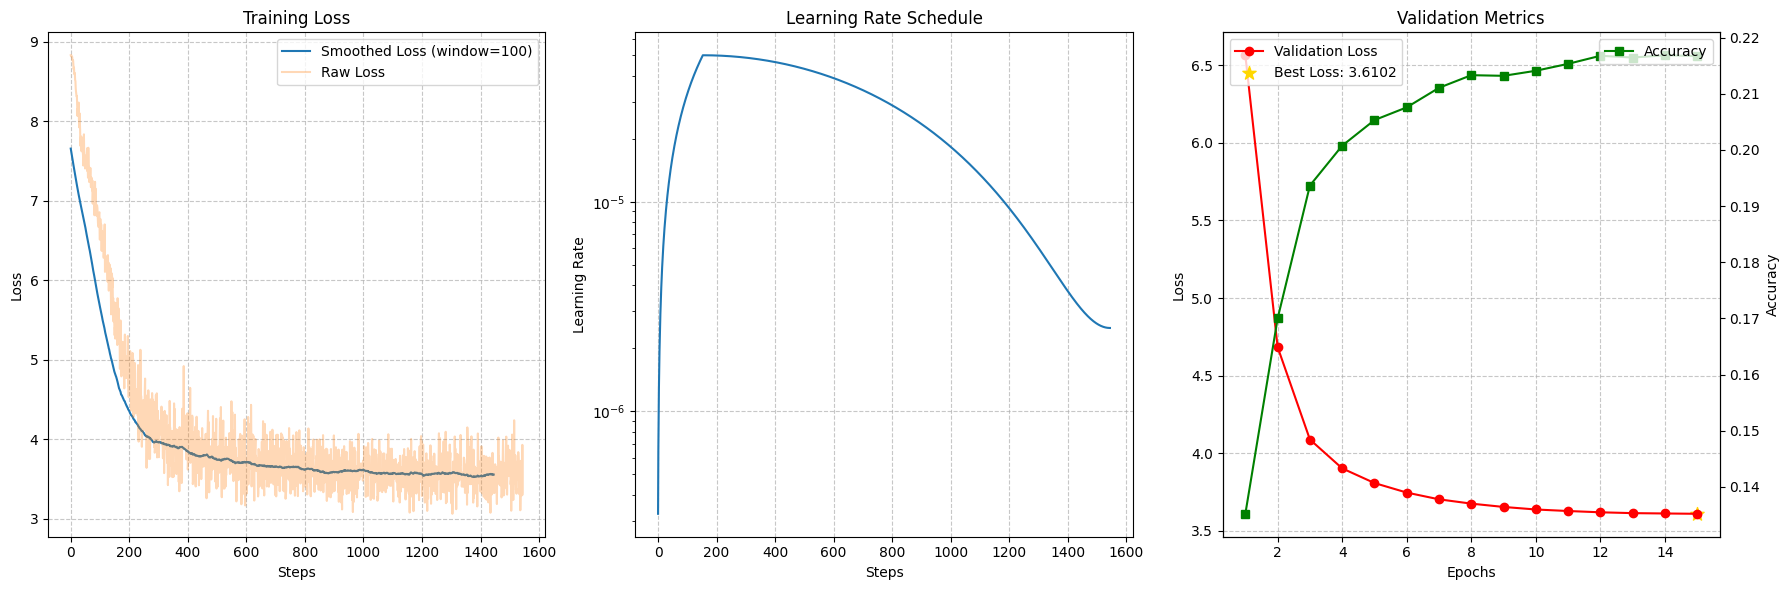

In [23]:
# =============================================================================
# PHASE 7: ENHANCED GPT MODEL TRAINING
# =============================================================================

def get_cosine_lr_scheduler(optimizer, total_steps, warmup_ratio=0.1, final_lr_ratio=0.1):
    """
    Creates a learning rate scheduler with linear warmup and cosine decay
    for more effective training of Transformer models.
    """
    warmup_steps = int(warmup_ratio * total_steps)
    decay_steps = total_steps - warmup_steps
    initial_lr = optimizer.param_groups[0]['lr']
    final_lr = initial_lr * final_lr_ratio

    if warmup_steps + decay_steps != total_steps:
        print(f"Warning: warmup ({warmup_steps}) + decay ({decay_steps}) != total ({total_steps}). Adjusting decay.")
        decay_steps = total_steps - warmup_steps

    def lr_lambda(current_step):
        # Warmup phase
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        # Cosine decay phase
        elif current_step < total_steps:
            progress = float(current_step - warmup_steps) / float(max(1, decay_steps))
            cosine_decay = 0.5 * (1.0 + math.cos(math.pi * progress))
            return final_lr_ratio + (1.0 - final_lr_ratio) * cosine_decay
        # Hold final LR after decay phase
        else:
            return final_lr_ratio

    return LambdaLR(optimizer, lr_lambda)


class EnhancedEarlyStopping:
    """
    Enhanced early stopping mechanism with improved checkpoint saving
    and configurable patience for better training outcomes.
    """
    def __init__(self, patience=3, min_delta=0.001, verbose=True, path='early_stopping_checkpoint.pt'):
        """
        Args:
            patience: How long to wait after last improvement before stopping
            min_delta: Minimum change to qualify as an improvement
            verbose: Whether to print messages for each validation loss improvement
            path: Path for the checkpoint to be saved
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model, optimizer, epoch, config, tokenizer_info, scheduler=None):
        """
        Call instance with current validation loss and save improved models.

        Args:
            val_loss: Current validation loss
            model: Model to save if improved
            optimizer: Optimizer state to save
            epoch: Current epoch number
            config: Model configuration
            tokenizer_info: Tokenizer information for saving
            scheduler: Optional scheduler state to save
        """
        # Check if this is the best model so far
        if val_loss < self.best_loss - self.min_delta:
            if self.verbose:
                improvement = self.best_loss - val_loss
                print(f"  EarlyStopping: Validation loss improved by {improvement:.6f}")
                print(f"  Previous: {self.best_loss:.6f} -> Current: {val_loss:.6f}")
            self.best_loss = val_loss
            self.counter = 0
            self.early_stop = False
            # Save the model checkpoint
            self.save_checkpoint(val_loss, model, optimizer, epoch, config, tokenizer_info, scheduler)
        else:
            self.counter += 1
            if self.verbose:
                print(f"  EarlyStopping: No improvement in validation loss. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("  EarlyStopping: Patience exhausted! Training will stop.")

        return self.early_stop

    def save_checkpoint(self, val_loss, model, optimizer, epoch, config, tokenizer_info, scheduler=None):
        """Saves model and training state when validation loss decreases."""
        try:
            # Create checkpoint dictionary with all relevant information
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': val_loss,
                'config': config.to_dict() if hasattr(config, 'to_dict') else config.__dict__,
                'tokenizer_info': tokenizer_info
            }

            # Add scheduler state if provided
            if scheduler is not None:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()

            # Save checkpoint to disk
            torch.save(checkpoint, self.path)

            if self.verbose:
                print(f"  Checkpoint saved to '{self.path}'")
        except Exception as e:
            print(f"  Error saving checkpoint: {e}")
            traceback.print_exc()


@torch.no_grad()
def evaluate_model(model, dataloader, device, config):
    """
    Evaluates the model on a given dataloader with enhanced metrics
    and improved handling of special tokens.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_batches = 0

    # Track additional metrics if needed
    total_tokens = 0
    total_correct = 0  # For accuracy (optional)

    # Use tqdm for progress bar
    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False, disable=True)

    pad_id = getattr(config, 'pad_token_id', -100)

    for x, y in progress_bar:
        try:
            # Move data to the correct device
            x, y = x.to(device), y.to(device)

            # Forward pass
            logits, loss = model(x, y)

            # Accumulate loss if valid
            if loss is not None and not torch.isnan(loss) and not torch.isinf(loss):
                batch_loss = loss.item()
                total_loss += batch_loss
                total_batches += 1

                # Compute additional metrics (optional)
                non_pad_mask = (y != pad_id)
                total_tokens += non_pad_mask.sum().item()

                # Calculate accuracy (optional)
                predictions = logits.argmax(dim=-1)
                correct = (predictions == y) & non_pad_mask
                total_correct += correct.sum().item()
            else:
                print("Warning: Invalid loss encountered during evaluation. Skipping batch.")

        except RuntimeError as e:
            print(f"Runtime error during evaluation: {e}")
            if "out of memory" in str(e).lower():
                print("CUDA out of memory. Skipping this batch.")
                # Attempt to clear GPU memory
                torch.cuda.empty_cache()
                continue
            else:
                raise e

    # Calculate final metrics
    avg_loss = total_loss / total_batches if total_batches > 0 else float('inf')
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0.0
    perplexity = math.exp(avg_loss) if avg_loss != float('inf') else float('inf')

    # Return to training mode
    model.train()

    return {
        'loss': avg_loss,
        'perplexity': perplexity,
        'accuracy': accuracy,
        'batches_processed': total_batches
    }


def clean_generated_text(tokenizer, generated_ids_tensor):
    """
    Cleans generated text output to produce more coherent results
    by properly handling special tokens and formatting issues.
    """
    if isinstance(generated_ids_tensor, torch.Tensor):
        generated_ids = generated_ids_tensor[0].tolist()  # Assumes batch size 1
    else:
        generated_ids = generated_ids_tensor

    # Identify special tokens to exclude
    special_tokens = set()
    if hasattr(tokenizer, 'special_token_ids'):
        special_tokens.update(tokenizer.special_token_ids.values())

    # Also exclude document marker tokens
    for i in range(min(200, tokenizer.vocab_size)):
        piece = tokenizer.convert_ids_to_tokens([i])[0]
        if '[DOC_' in piece:
            special_tokens.add(i)

    # Filter out special tokens
    clean_ids = [id for id in generated_ids if id not in special_tokens]

    # Decode using the tokenizer's built-in method
    text = tokenizer.decode(clean_ids, skip_special_tokens=True)

    # Additional text cleaning
    text = re.sub(r'\s{2,}', ' ', text)  # Remove multiple spaces
    text = re.sub(r'(\w)[,.] (\w)', r'\1, \2', text)  # Fix punctuation spacing

    # Properly capitalize common proper nouns for Harry Potter
    for name in ["harry", "ron", "hermione", "dumbledore", "hogwarts", "gryffindor", "slytherin",
                "hufflepuff", "ravenclaw", "voldemort", "potter"]:
        text = re.sub(fr'\b{name}\b', name.capitalize(), text, flags=re.IGNORECASE)

    return text.strip()


def train_model(model, config, tokenizer, tokens, val_split=0.1, model_save_prefix='gpt_trained_model'):
    """
    Enhanced training function with improved handling of gradients,
    mixed precision, and better monitoring of training progress.
    """
    print("\n" + "="*60)
    print("PHASE 7: ENHANCED GPT MODEL TRAINING")
    print("="*60)

    # 1. Validate Inputs and Setup Device
    if not all([model, config, tokenizer]) or tokens is None:
        print("Error: Missing required arguments (model, config, tokenizer, or tokens).")
        return None
    if not tokens:
        print("Error: Token list is empty. Cannot train.")
        return model

    try:
        device = next(model.parameters()).device
    except StopIteration:
        print("Error: Model has no parameters. Cannot determine device.")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Defaulting to device: {device}")

    print(f"Training device: {device}")
    print(f"Configuration summary:")
    print(f"  - Vocabulary size: {config.vocab_size}")
    print(f"  - Context length: {config.context_length}")
    print(f"  - Embedding dimension: {config.embed_dim}")
    print(f"  - Number of layers: {config.num_layers}")
    print(f"  - Learning rate: {config.learning_rate}")
    print(f"  - Epochs: {config.num_epochs}")

    # 2. Prepare Datasets and DataLoaders
    print("\nPreparing Datasets and DataLoaders...")
    try:
        # Improved dataset with dynamic context length
        full_dataset = EnhancedGPTDataset(
            tokens,
            config.context_length,
            config.pad_token_id,
            stride=config.context_length // 2
        )

        if len(full_dataset) == 0:
            print("Error: Dataset created has 0 samples. Check tokens and context length.")
            return model

        train_dataset, val_dataset = None, None

        # Split dataset for validation if ratio is valid
        if 0 < val_split < 1:
            val_size = int(val_split * len(full_dataset))
            train_size = len(full_dataset) - val_size

            if train_size > 0 and val_size > 0:
                # Set seeds for reproducibility
                generator = torch.Generator().manual_seed(42)
                train_dataset, val_dataset = random_split(
                    full_dataset, [train_size, val_size],
                    generator=generator
                )
            else:
                train_dataset = full_dataset
                print(f"Warning: Not enough samples for validation split. Using all data for training.")
        else:
            train_dataset = full_dataset
            print("Using all data for training (no validation split).")

        if train_dataset:
            print(f"Training Dataset: {len(train_dataset)} samples")
        if val_dataset:
            print(f"Validation Dataset: {len(val_dataset)} samples")

        # Determine optimal number of workers based on CPU cores
        num_workers = min(4, os.cpu_count() // 2 if os.cpu_count() else 1)
        num_workers = max(0, num_workers)  # Ensure non-negative
        print(f"Using {num_workers} dataloader workers")

        # Create DataLoaders
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=config.batch_size,
            shuffle=True,
            pin_memory=(device.type == 'cuda'),
            num_workers=num_workers,
            drop_last=True
        ) if train_dataset else None

        val_dataloader = DataLoader(
            val_dataset,
            batch_size=config.batch_size * 2,  # Larger batch size for validation
            shuffle=False,
            pin_memory=(device.type == 'cuda'),
            num_workers=num_workers,
            drop_last=False
        ) if val_dataset else None

        if not train_dataloader:
            print("Error: Could not create training DataLoader.")
            return model

    except Exception as e:
        print(f"Error creating Datasets/DataLoaders: {e}")
        traceback.print_exc()
        return model

    # 3. Configure Optimizer and Scheduler
    print("\nConfiguring Optimizer and Scheduler...")

    # Group parameters for different weight decay settings
    # This is a common optimization technique for transformer models
    decay_params = []
    no_decay_params = []

    for name, param in model.named_parameters():
        # Skip parameters that don't require gradients
        if not param.requires_grad:
            continue

        # Apply weight decay to linear layers' weights, but not to biases, layer norms, or embeddings
        if 'bias' in name or 'ln' in name or 'norm' in name or 'embedding' in name:
            no_decay_params.append(param)
        else:
            decay_params.append(param)

    optimizer_params = [
        {'params': decay_params, 'weight_decay': config.weight_decay},
        {'params': no_decay_params, 'weight_decay': 0.0}
    ]

    # AdamW optimizer with improved parameters
    optimizer = torch.optim.AdamW(
        optimizer_params,
        lr=config.learning_rate,
        betas=(0.9, 0.95),  # Slightly modified beta2 for better training
        eps=1e-8
    )

    # Calculate total training steps for scheduler
    steps_per_epoch = len(train_dataloader)
    total_steps = config.num_epochs * steps_per_epoch

    if total_steps == 0:
        print("Error: Calculated total_steps is 0. Check dataloader length and num_epochs.")
        return model

    print(f"Steps per epoch: {steps_per_epoch}, Total training steps: {total_steps}")

    # Create learning rate scheduler with warmup and decay
    warmup_ratio = getattr(config, 'warmup_ratio', 0.1)
    final_lr_ratio = getattr(config, 'final_lr_ratio', 0.1)

    scheduler = get_cosine_lr_scheduler(
        optimizer,
        total_steps,
        warmup_ratio=warmup_ratio,
        final_lr_ratio=final_lr_ratio
    )

    print(f"Using cosine LR scheduler with {int(warmup_ratio*100)}% warmup and {int(final_lr_ratio*100)}% final LR")

    # 4. Setup Mixed Precision Training (if available)
    use_mixed_precision = torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    if use_mixed_precision:
        print("Using mixed precision training (FP16)")
    else:
        print("Mixed precision not available, using FP32")

    # 5. Initialize Early Stopping and Tracking
    # Only use early stopping if validation set exists
    early_stopping_path = f'{model_save_prefix}_early_stopping.pt'
    early_stopping = EnhancedEarlyStopping(
        patience=3,
        verbose=True,
        path=early_stopping_path
    ) if val_dataloader else None

    if early_stopping:
        print(f"Early stopping enabled (patience=3). Best model will save to '{early_stopping_path}'")

    # Lists to store metrics for plotting
    train_losses = []
    val_metrics = []
    learning_rates = []

    best_val_loss = float('inf')
    start_time = time.time()

    # Tokenizer info for saving checkpoints
    tokenizer_info_for_save = {
        'prefix': tokenizer.model_prefix,
        'vocab_size': tokenizer.vocab_size,
        'pad_id': tokenizer.pad_id,
        'info_path': tokenizer.info_path
    }

    # 6. Training Loop
    print(f"\n--- Starting Training ({config.num_epochs} epochs) ---")
    global_step = 0
    training_interrupted = False
    last_completed_epoch = -1
    accumulation_steps = getattr(config, 'gradient_accumulation_steps', 1)

    if accumulation_steps > 1:
        print(f"Using gradient accumulation with {accumulation_steps} steps")
        effective_batch_size = config.batch_size * accumulation_steps
        print(f"Effective batch size: {effective_batch_size}")

    try:
        for epoch in range(config.num_epochs):
            epoch_start_time = time.time()
            model.train()
            epoch_loss = 0.0
            steps_this_epoch = 0

            # Progress bar for current epoch
            progress_bar = tqdm(
                train_dataloader,
                desc=f"Epoch {epoch+1}/{config.num_epochs}",
                leave=True
            )

            # Training loop for one epoch
            for batch_idx, (x, y) in enumerate(progress_bar):
                # Normalize batch step for accumulation
                is_accumulation_step = (batch_idx + 1) % accumulation_steps != 0

                try:
                    # Move data to device
                    x, y = x.to(device), y.to(device)

                    # Forward pass with mixed precision if available
                    if use_mixed_precision:
                        with torch.cuda.amp.autocast():
                            logits, loss = model(x, y)
                            # Scale loss for gradient accumulation if needed
                            if accumulation_steps > 1:
                                loss = loss / accumulation_steps
                    else:
                        logits, loss = model(x, y)
                        if accumulation_steps > 1:
                            loss = loss / accumulation_steps

                    # Skip problematic batches
                    if loss is None or torch.isnan(loss) or torch.isinf(loss):
                        print(f"Warning: Invalid loss at step {global_step}. Skipping batch.")
                        continue

                    # Backward pass with scaled gradients if using mixed precision
                    if use_mixed_precision:
                        scaler.scale(loss).backward()
                    else:
                        loss.backward()

                    # Only step optimizer and scheduler on non-accumulation steps
                    if not is_accumulation_step or (batch_idx + 1 == len(progress_bar)):
                        # Apply gradient clipping
                        if use_mixed_precision:
                            scaler.unscale_(optimizer)

                        clip_value = getattr(config, 'gradient_clip_val', 1.0)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

                        # Update weights
                        if use_mixed_precision:
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            optimizer.step()

                        # Update learning rate
                        scheduler.step()
                        learning_rates.append(scheduler.get_last_lr()[0])

                        # Reset gradients
                        optimizer.zero_grad(set_to_none=True)

                        # Increment global step after full accumulation cycle
                        global_step += 1

                    # Track loss and steps
                    epoch_loss += loss.item() * (1 if accumulation_steps == 1 else accumulation_steps)
                    steps_this_epoch += 1

                    # Update progress bar
                    current_lr = scheduler.get_last_lr()[0]
                    avg_loss = epoch_loss / steps_this_epoch if steps_this_epoch > 0 else 0
                    progress_bar.set_postfix({
                        'loss': f"{loss.item():.4f}",
                        'avg_loss': f"{avg_loss:.4f}",
                        'lr': f"{current_lr:.2e}"
                    })

                    # Track training loss for plotting
                    if not is_accumulation_step or (batch_idx + 1 == len(progress_bar)):
                        train_losses.append(loss.item() * (1 if accumulation_steps == 1 else accumulation_steps))

                except RuntimeError as e:
                    if "out of memory" in str(e).lower():
                        print(f"WARNING: CUDA out of memory at batch {batch_idx}. Skipping batch.")
                        # Try to free memory
                        if use_mixed_precision:
                            scaler._clear_cache()
                        torch.cuda.empty_cache()
                        # Skip to next batch
                        continue
                    else:
                        print(f"Runtime error during training: {e}")
                        traceback.print_exc()
                        raise e

            # End of epoch
            epoch_duration = time.time() - epoch_start_time
            avg_epoch_loss = epoch_loss / steps_this_epoch if steps_this_epoch > 0 else 0.0
            print(f"\nEpoch {epoch+1}/{config.num_epochs} completed in {epoch_duration:.2f}s")
            print(f"Average training loss: {avg_epoch_loss:.4f}")

            # Generate sample text after each epoch to check progress
            if tokenizer:
                try:
                    prompt = tokenizer.special_tokens.get('bos_token', '') + " Harry looked at "
                    input_ids = tokenizer.encode(prompt, add_bos=False, add_eos=False)
                    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

                    model.eval()
                    with torch.no_grad():
                        generated_ids = model.generate(
                            idx=input_tensor,
                            max_new_tokens=40,
                            temperature=0.7,
                            top_k=50,
                            top_p=0.9,
                            tokenizer=tokenizer
                        )

                    generated_text = clean_generated_text(tokenizer, generated_ids)
                    print(f"\nSample generation: '{generated_text}'")
                    model.train()
                except Exception as e:
                    print(f"Error generating sample: {e}")

            # Validation Step
            if val_dataloader:
                print("\nRunning validation...")
                val_metrics_dict = evaluate_model(model, val_dataloader, device, config)
                val_loss = val_metrics_dict['loss']
                val_ppl = val_metrics_dict['perplexity']
                val_accuracy = val_metrics_dict.get('accuracy', 0.0)

                val_metrics.append(val_metrics_dict)

                print(f"Validation Loss: {val_loss:.4f}, Perplexity: {val_ppl:.4f}, Accuracy: {val_accuracy:.4f}")

                # Save best model based on validation loss
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_path = f'{model_save_prefix}_best_val.pt'
                    checkpoint = {
                        'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_val_loss': best_val_loss,
                        'config': config.to_dict() if hasattr(config, 'to_dict') else config.__dict__,
                        'tokenizer_info': tokenizer_info_for_save
                    }
                    try:
                        torch.save(checkpoint, best_model_path)
                        print(f"✓ New best validation model saved: '{best_model_path}'")
                    except Exception as e:
                        print(f"✗ Error saving best validation checkpoint: {e}")

                # Check early stopping
                if early_stopping:
                    if early_stopping(val_loss, model, optimizer, epoch, config,
                                     tokenizer_info_for_save, scheduler):
                        print("\n--- Early Stopping Triggered ---")
                        break

            # Save regular checkpoint at end of each epoch
            checkpoint_path = f'{model_save_prefix}_epoch{epoch+1}.pt'
            try:
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_loss': avg_epoch_loss,
                    'val_loss': val_loss if val_dataloader else None,
                    'config': config.to_dict() if hasattr(config, 'to_dict') else config.__dict__,
                    'tokenizer_info': tokenizer_info_for_save
                }
                torch.save(checkpoint, checkpoint_path)
                print(f"Epoch {epoch+1} checkpoint saved: '{checkpoint_path}'")
            except Exception as e:
                print(f"Error saving epoch checkpoint: {e}")

            last_completed_epoch = epoch

    except KeyboardInterrupt:
        print("\n--- Training Interrupted Manually ---")
        training_interrupted = True
    except Exception as e:
        print(f"\n--- Error During Training: {e} ---")
        traceback.print_exc()
        training_interrupted = True

    # 7. End of Training
    total_training_time = time.time() - start_time
    status = "Interrupted" if training_interrupted else "Completed"
    print(f"\n--- Training {status} ---")
    print(f"Total Training Time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")

    if val_dataloader:
        print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Last completed epoch: {last_completed_epoch + 1}")

    # 8. Save Final Model
    final_model_path = f'{model_save_prefix}_final.pt'
    try:
        checkpoint = {
            'epoch': last_completed_epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_loss': avg_epoch_loss if 'avg_epoch_loss' in locals() else None,
            'val_loss': val_loss if 'val_loss' in locals() else None,
            'config': config.to_dict() if hasattr(config, 'to_dict') else config.__dict__,
            'tokenizer_info': tokenizer_info_for_save
        }
        torch.save(checkpoint, final_model_path)
        print(f"Final model checkpoint saved: '{final_model_path}'")
    except Exception as e:
        print(f"Error saving final model checkpoint: {e}")

    # 9. Generate Learning Curves
    print("\nGenerating learning curves plot...")
    try:
        plt.figure(figsize=(18, 6))

        # Plot 1: Training Loss
        plt.subplot(1, 3, 1)
        if len(train_losses) > 100:
            # Apply smoothing for readability
            window_size = min(100, len(train_losses) // 10)
            smoothed_losses = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
            plt.plot(smoothed_losses, label=f'Smoothed Loss (window={window_size})')
            plt.plot(train_losses, alpha=0.3, label='Raw Loss')
        else:
            plt.plot(train_losses, label='Training Loss')

        plt.title('Training Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)

        # Plot 2: Learning Rate
        plt.subplot(1, 3, 2)
        if learning_rates:
            plt.plot(learning_rates)
            plt.title('Learning Rate Schedule')
            plt.xlabel('Steps')
            plt.ylabel('Learning Rate')
            plt.grid(True, linestyle='--', alpha=0.7)
            # Use log scale for better visualization
            plt.yscale('log')
        else:
            plt.title('Learning Rate (No Data)')

        # Plot 3: Validation Metrics
        plt.subplot(1, 3, 3)
        if val_metrics:
            epochs = range(1, len(val_metrics) + 1)
            val_losses = [m['loss'] for m in val_metrics]

            # Primary y-axis: Validation Loss
            plt.plot(epochs, val_losses, 'o-', color='r', label='Validation Loss')

            # Highlight best validation loss
            if val_losses:
                best_idx = np.argmin(val_losses)
                best_epoch = epochs[best_idx]
                best_loss = val_losses[best_idx]
                plt.scatter([best_epoch], [best_loss], color='gold', s=100,
                            marker='*', label=f'Best Loss: {best_loss:.4f}')

            plt.title('Validation Metrics')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend(loc='upper left')

            # Secondary y-axis: Accuracy (if available)
            if 'accuracy' in val_metrics[0]:
                ax2 = plt.twinx()
                accuracies = [m['accuracy'] for m in val_metrics]
                ax2.plot(epochs, accuracies, 's-', color='g', label='Accuracy')
                ax2.set_ylabel('Accuracy')
                ax2.legend(loc='upper right')
        else:
            plt.title('Validation Metrics (No Data)')

        plt.tight_layout()
        plot_path = f'{model_save_prefix}_learning_curves.png'
        plt.savefig(plot_path)
        print(f"Learning curves plot saved to '{plot_path}'")

    except Exception as e:
        print(f"Error generating learning curves plot: {e}")
        traceback.print_exc()

    # 10. Post-Training Sample Generation
    print("\nGenerating final text samples...")
    try:
        if tokenizer and model:
            model.eval()  # Set to evaluation mode

            # Generate samples with different temperatures
            prompts = [
                "Harry Potter looked at the",
                "Hermione whispered to Ron",
                "Dumbledore raised his wand and",
                "The Hogwarts castle was"
            ]

            print("\n==== Final Model Text Samples ====")
            for prompt in prompts:
                input_ids = tokenizer.encode(prompt, add_bos=True, add_eos=False)
                input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

                # Generate with moderate temperature
                with torch.no_grad():
                    generated_ids = model.generate(
                        idx=input_tensor,
                        max_new_tokens=80,
                        temperature=0.7,
                        top_k=50,
                        top_p=0.9,
                        tokenizer=tokenizer
                    )

                clean_text = clean_generated_text(tokenizer, generated_ids)
                print(f"\nPrompt: '{prompt}'")
                print(f"Generated (temp=0.7): '{clean_text}'")

    except Exception as e:
        print(f"Error generating final samples: {e}")
        traceback.print_exc()

    print("\n" + "="*60)
    print("PHASE 7: TRAINING COMPLETE")
    print("="*60)

    return model


# --- EXECUTE PHASE 7 ---

print("\n--- Starting Phase 7 Execution ---")

# Check if necessary variables exist from Phase 6
if ('model_p6' in locals() and model_p6 is not None and
    'config_p6' in locals() and config_p6 is not None and
    'tokenizer_p6' in locals() and tokenizer_p6 is not None and
    'tokens_p6' in locals() and tokens_p6 is not None):

    print("Variables from Phase 6 found. Proceeding to training...")

    # --- Training Parameters ---
    VAL_SPLIT_RATIO_P7 = 0.05  # Use 5% of data for validation
    # Prefix for saving model checkpoints and plots
    MODEL_SAVE_PREFIX_P7 = "gpt_harry_potter_trained"

    # --- Call the Training Function ---
    # Pass the objects obtained from Phase 6
    trained_model_p7 = train_model(
        model=model_p6,
        config=config_p6,
        tokenizer=tokenizer_p6,
        tokens=tokens_p6,
        val_split=VAL_SPLIT_RATIO_P7,
        model_save_prefix=MODEL_SAVE_PREFIX_P7
    )

    # --- Quick Post-Training Test (Optional) ---
    if trained_model_p7:
        print("\n--- Quick Post-Training Test ---")
        # Ensure correct model and tokenizer are used
        current_model = trained_model_p7
        current_tokenizer = tokenizer_p6 # Use the tokenizer passed to train_model

        try:
            device_p7 = next(current_model.parameters()).device
        except StopIteration:
            device_p7 = torch.device('cpu') # Fallback if model has no params
            print("Warning: Model has no parameters, setting device to CPU.")

        current_model.eval() # Set model to evaluation mode

        # Get the BOS token string from the tokenizer
        try:
            bos_token_string = current_tokenizer.special_tokens.get('bos_token', '[BOS]')
            if not bos_token_string: # Handle empty string case
                 bos_token_string = "" # Or maybe "[UNK]"? Let's use empty for now.
        except Exception:
            print("Warning: Could not get 'bos_token' from tokenizer. Using empty start.")
            bos_token_string = "" # Fallback

        # Example prompt
        prompt_p7 = bos_token_string + " Harry looked around the" if bos_token_string else "Harry looked around the"
        print(f"Prompt: {prompt_p7}")

        # Check if prompt is empty after potential BOS addition
        if not prompt_p7.strip():
             print("Error: Prompt is empty, cannot generate.")
        else:
            try:
                # Encode the prompt
                input_ids_p7 = current_tokenizer.encode(prompt_p7, add_bos=False, add_eos=False)
                # Handle case where encoding returns empty list (e.g., only OOV tokens?)
                if not input_ids_p7:
                     print(f"Warning: Encoding prompt '{prompt_p7}' resulted in empty list. Using UNK token.")
                     input_ids_p7 = [current_tokenizer.unk_id]

                input_tensor_p7 = torch.tensor([input_ids_p7], dtype=torch.long).to(device_p7)

                # Generate text
                with torch.no_grad():
                    generated_ids_p7 = current_model.generate(
                        idx=input_tensor_p7,
                        max_new_tokens=100, # Generate more tokens
                        temperature=0.7,    # Moderate temperature for coherence
                        top_k=40,           # Use top-k sampling
                        tokenizer=current_tokenizer # Pass tokenizer for EOS detection
                    )

                # Clean and format the generated text
                clean_generated_text = clean_generated_text(current_tokenizer, generated_ids_p7)

                print(f"\nGenerated Text: {clean_generated_text}")

            except Exception as e_gen:
                print(f"Error during post-training generation: {e_gen}")
                traceback.print_exc()
    else:
        print("\nTraining did not complete or failed, cannot perform post-training test.")

else:
    print("\nCritical Error: Required variables from Phase 6 (model_p6, config_p6, tokenizer_p6, tokens_p6) are not defined or are None.")
    print("Ensure Phase 6 completed successfully without errors before running Phase 7.")
    print("Check the logs from Phase 6 for potential issues.")

#Phase 8: Gradio Interface
🖥️ Creates interactive web UI for text generation. 🎛️ Provides controls for generation parameters (temperature, top-k, top-p). ✨ Implements clean text formatting with special token handling. 📋 Displays model information and training details. 🔄 Includes example prompts for easy demonstration of capabilities.

In [24]:
# =============================================================================
# PHASE 8: ENHANCED GRADIO INTERFACE FOR TEXT GENERATION
# =============================================================================

def clean_generated_text_helper(tokenizer, generated_ids_tensor):
    """
    Cleans generated text output to produce more coherent results
    by properly handling special tokens and formatting issues.
    """
    if isinstance(generated_ids_tensor, torch.Tensor):
        generated_ids = generated_ids_tensor[0].tolist()  # Assumes batch size 1
    else:
        generated_ids = generated_ids_tensor

    # Identify special tokens to exclude
    special_tokens = set()
    if hasattr(tokenizer, 'special_token_ids'):
        special_tokens.update(tokenizer.special_token_ids.values())

    # Also exclude document marker tokens
    for i in range(min(200, tokenizer.vocab_size)):
        piece = tokenizer.convert_ids_to_tokens([i])[0]
        if '[DOC_' in piece:
            special_tokens.add(i)

    # Filter out special tokens
    clean_ids = [id for id in generated_ids if id not in special_tokens]

    # Decode using the tokenizer's built-in method
    text = tokenizer.decode(clean_ids, skip_special_tokens=True)

    # Additional text cleaning
    text = re.sub(r'\s{2,}', ' ', text)  # Remove multiple spaces
    text = re.sub(r'(\w)[,.] (\w)', r'\1, \2', text)  # Fix punctuation spacing

    # Properly capitalize common proper nouns for Harry Potter
    for name in ["harry", "ron", "hermione", "dumbledore", "hogwarts", "gryffindor", "slytherin",
                "hufflepuff", "ravenclaw", "voldemort", "potter"]:
        text = re.sub(fr'\b{name}\b', name.capitalize(), text, flags=re.IGNORECASE)

    return text.strip()


def load_model_for_inference(model_path):
    """
    Loads a trained model and associated configuration/tokenizer info from a checkpoint
    with enhanced error handling and compatibility checks.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model checkpoint not found at '{model_path}'")

    # Load checkpoint onto CPU first to avoid GPU memory issues
    try:
        checkpoint = torch.load(model_path, map_location='cpu')
        print(f"Checkpoint loaded from {model_path}")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        raise e

    # Load configuration from checkpoint
    try:
        if 'config' in checkpoint and isinstance(checkpoint['config'], dict):
            config_dict = checkpoint['config']
            # Create config instance
            config = EnhancedTransformerConfig.from_dict(config_dict)
            print(f"Configuration loaded from checkpoint (Vocab: {config.vocab_size}, Layers: {config.num_layers})")
        else:
            raise ValueError("Valid 'config' dictionary not found in checkpoint.")
    except Exception as e:
        print(f"Error loading configuration from checkpoint: {e}")
        raise e

    # Instantiate the model with the loaded configuration
    try:
        model = EnhancedGPT(config)
        print(f"Model initialized with configuration")
    except Exception as e:
        print(f"Error initializing model: {e}")
        raise e

    # Load the model's state dictionary
    try:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model weights loaded successfully")
    except Exception as e:
        print(f"Error loading model weights: {e}")

        # Try one more time with strict=False
        try:
            print("Attempting to load with strict=False...")
            model.load_state_dict(checkpoint['model_state_dict'], strict=False)
            print("Model weights loaded with strict=False (some weights may be missing)")
        except Exception as e2:
            print(f"Failed with strict=False as well: {e2}")
            raise e

    # Get tokenizer information from the checkpoint
    tokenizer_info = checkpoint.get('tokenizer_info', {})
    tokenizer_prefix = tokenizer_info.get('prefix', 'spm_harry_potter')

    if not tokenizer_prefix:
        print("Warning: Tokenizer prefix not found in checkpoint info. Using default 'spm_harry_potter'.")
        tokenizer_prefix = 'spm_harry_potter'

    print(f"Tokenizer prefix from checkpoint: '{tokenizer_prefix}'")

    # Additional metadata for UI
    metadata = {
        "epoch": checkpoint.get("epoch", "Unknown"),
        "val_loss": checkpoint.get("best_val_loss", checkpoint.get("val_loss", "Unknown")),
        "train_loss": checkpoint.get("train_loss", "Unknown"),
        "model_path": model_path,
        "tokenizer_prefix": tokenizer_prefix
    }

    return model, config, tokenizer_prefix, metadata


def generate_text_with_model(
    prompt,
    model,
    tokenizer,
    device,
    max_new_tokens=100,
    temperature=0.7,
    top_k=50,
    top_p=0.9,
    add_bos=True,
    use_sampling=True
):
    """
    Generates text using the provided model and tokenizer with enhanced settings
    for better quality and coherence.
    """
    if not prompt or not prompt.strip():
        return "Please enter a prompt to generate text."

    model.eval()  # Set model to evaluation mode

    try:
        # Process prompt
        if add_bos:
            bos_token = tokenizer.special_tokens.get('bos_token', '')
            full_prompt = (bos_token + " " + prompt).strip() if bos_token else prompt
        else:
            full_prompt = prompt

        # Tokenize prompt
        input_ids = tokenizer.encode(full_prompt, add_bos=False, add_eos=False)

        # Handle empty encoding
        if not input_ids:
            print(f"Warning: Encoding the prompt returned empty. Using UNK token.")
            input_ids = [tokenizer.unk_id]

        # Convert to tensor and move to device
        input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

        # Generate text
        with torch.no_grad():
            # Choose appropriate generation method
            if not use_sampling and temperature == 0:
                # Pure greedy decoding
                generated_ids = model.generate(
                    idx=input_tensor,
                    max_new_tokens=max_new_tokens,
                    temperature=0,
                    top_k=None,
                    top_p=None,
                    tokenizer=tokenizer
                )
            else:
                # Sampling with temperature, top_k, and top_p
                generated_ids = model.generate(
                    idx=input_tensor,
                    max_new_tokens=max_new_tokens,
                    temperature=temperature,
                    top_k=top_k if top_k > 0 else None,
                    top_p=top_p if 0 < top_p < 1 else None,
                    tokenizer=tokenizer
                )

        # Clean and format the generated text
        generated_text = clean_generated_text_helper(tokenizer, generated_ids)

        # Extract only the part that was newly generated (not in the prompt)
        prompt_normalized = prompt.strip()
        if generated_text.startswith(prompt_normalized):
            generated_only = generated_text[len(prompt_normalized):].strip()
            full_text = prompt_normalized + " " + generated_only
        else:
            # In case the prompt was modified during tokenization/generation
            full_text = generated_text

        return full_text

    except Exception as e:
        print(f"Error during text generation: {e}")
        traceback.print_exc()
        return f"Error generating text: {str(e)}"


def create_gradio_interface(model_path, default_tokenizer_prefix="spm_harry_potter"):
    """
    Creates an enhanced Gradio interface for the Harry Potter text generator
    with improved controls and visualization.
    """
    try:
        # Load model, config, and tokenizer info
        model, config, tokenizer_prefix, metadata = load_model_for_inference(model_path)

        # Use tokenizer prefix from model or default
        if tokenizer_prefix:
            print(f"Using tokenizer prefix from model: '{tokenizer_prefix}'")
        else:
            tokenizer_prefix = default_tokenizer_prefix
            print(f"Using default tokenizer prefix: '{tokenizer_prefix}'")

        # Load tokenizer
        tokenizer = EnhancedSentencePieceTokenizer()
        tokenizer.load(tokenizer_prefix)

        # Set device for inference
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        print(f"Model loaded on device: {device}")

        # Example prompts for the interface
        example_prompts = [
            "Harry looked at Hermione and",
            "The castle of Hogwarts stood",
            "Professor Dumbledore raised his wand and",
            "Ron Weasley couldn't believe his eyes when",
            "The Sorting Hat spoke in a deep voice",
            "Hagrid's hut was"
        ]

        # Gradio interface function
        def generate_text(
            prompt,
            max_tokens,
            temperature,
            top_k,
            top_p,
            add_bos_token,
            use_sampling,
            show_special_tokens
        ):
            result = generate_text_with_model(
                prompt=prompt,
                model=model,
                tokenizer=tokenizer,
                device=device,
                max_new_tokens=int(max_tokens),
                temperature=float(temperature) if use_sampling else 0.0,
                top_k=int(top_k) if top_k > 0 and use_sampling else None,
                top_p=float(top_p) if 0 < top_p < 1 and use_sampling else None,
                add_bos=add_bos_token,
                use_sampling=use_sampling
            )

            # If showing special tokens is requested, display raw token information
            if show_special_tokens:
                # Get tokens for the prompt and generated text
                all_token_ids = tokenizer.encode(result, add_bos=False, add_eos=False)
                token_pieces = tokenizer.convert_ids_to_tokens(all_token_ids)

                # Format for display
                tokens_display = []
                for i, (token_id, piece) in enumerate(zip(all_token_ids, token_pieces)):
                    # Show index, ID, and the token piece
                    tokens_display.append(f"[{i}] ID:{token_id} → '{piece}'")

                # Add token information to the result
                result = result + "\n\n--- Token Information ---\n" + "\n".join(tokens_display)

            return result

        # Create Gradio interface
        with gr.Blocks(title="🧙‍♂️ HarryPotterGPT Enhanced") as demo:
            gr.Markdown("# 🧙‍♂️ HarryPotterGPT Enhanced")
            gr.Markdown("Generate text in the style of Harry Potter. Enter a prompt and let the magic happen!")

            with gr.Row():
                # Main content column
                with gr.Column(scale=3):
                    prompt_input = gr.Textbox(
                        placeholder="Enter a prompt (e.g., 'Harry looked at the castle and')",
                        label="Prompt",
                        lines=3
                    )

                    with gr.Row():
                        generate_btn = gr.Button("✨ Generate Text", variant="primary")
                        clear_btn = gr.Button("🧹 Clear")

                    output_text = gr.Textbox(
                        label="Generated Text",
                        lines=10
                    )

                    gr.Markdown("### Examples")
                    examples = gr.Examples(
                        examples=example_prompts,
                        inputs=prompt_input
                    )

                # Settings column
                with gr.Column(scale=1):
                    gr.Markdown("### Generation Settings")

                    with gr.Group():
                        max_tokens_slider = gr.Slider(
                            minimum=10, maximum=300, value=100, step=10,
                            label="Maximum New Tokens"
                        )

                        use_sampling = gr.Checkbox(
                            value=True,
                            label="Use Sampling (vs. Greedy Decoding)"
                        )

                        with gr.Group(visible=True) as sampling_group:
                            temperature_slider = gr.Slider(
                                minimum=0.1, maximum=1.5, value=0.7, step=0.1,
                                label="Temperature"
                            )

                            top_k_slider = gr.Slider(
                                minimum=0, maximum=100, value=50, step=5,
                                label="Top-K"
                            )

                            top_p_slider = gr.Slider(
                                minimum=0.0, maximum=1.0, value=0.9, step=0.05,
                                label="Top-P (Nucleus Sampling)"
                            )

                    gr.Markdown("### Advanced Options")
                    with gr.Accordion("Advanced", open=False):
                        add_bos_token = gr.Checkbox(
                            value=True,
                            label="Add BOS Token"
                        )

                        show_special_tokens = gr.Checkbox(
                            value=False,
                            label="Show Token Information"
                        )

                    # Model information card
                    with gr.Accordion("Model Information", open=False):
                        model_info = f"""
                        **Model**: HarryPotterGPT
                        **Architecture**: {config.num_layers}-layer Transformer
                        **Dimensions**: {config.embed_dim}d embeddings, {config.num_heads} attention heads
                        **Vocabulary Size**: {config.vocab_size} tokens
                        **Context Length**: {config.context_length} tokens
                        **Device**: {device}
                        **Training**: {metadata.get('epoch', 'Unknown')} epochs
                        **Validation Loss**: {metadata.get('val_loss', 'Unknown')}
                        """
                        gr.Markdown(model_info)

            # Connect components
            generate_btn.click(
                generate_text,
                inputs=[
                    prompt_input,
                    max_tokens_slider,
                    temperature_slider,
                    top_k_slider,
                    top_p_slider,
                    add_bos_token,
                    use_sampling,
                    show_special_tokens
                ],
                outputs=output_text
            )

            clear_btn.click(
                lambda: "",
                inputs=None,
                outputs=output_text
            )

            # Make sampling controls dependent on use_sampling checkbox
            use_sampling.change(
                lambda x: gr.update(visible=x),
                inputs=use_sampling,
                outputs=sampling_group
            )

        return demo

    except Exception as e:
        print(f"Error creating Gradio interface: {e}")
        traceback.print_exc()

        # Create a fallback interface if there's an error
        with gr.Blocks(title="🧙‍♂️ HarryPotterGPT - Error") as error_demo:
            gr.Markdown("# ❌ Error Loading HarryPotterGPT")
            gr.Markdown(f"There was an error initializing the application:\n\n```\n{str(e)}\n```")
            gr.Markdown("Please check the model path and that all required files exist.")

        return error_demo


# --- EXECUTE PHASE 8 ---
if __name__ == "__main__":
    # Configuration
    MODEL_PATH = f"{MODEL_SAVE_PREFIX_P7}_final.pt" if 'MODEL_SAVE_PREFIX_P7' in locals() else "gpt_harry_potter_trained_final.pt"
    TOKENIZER_PREFIX = TOKENIZER_PREFIX_P4 if 'TOKENIZER_PREFIX_P4' in locals() else "spm_harry_potter"

    print(f"\n--- Setting up Gradio Interface ---")
    print(f"Model path: {MODEL_PATH}")
    print(f"Tokenizer prefix: {TOKENIZER_PREFIX}")

    # Check if the model file exists
    if not os.path.exists(MODEL_PATH):
        # Try to find best model if final not available
        best_val_path = MODEL_PATH.replace("_final.pt", "_best_val.pt")
        if os.path.exists(best_val_path):
            MODEL_PATH = best_val_path
            print(f"Final model not found. Using best validation model: {MODEL_PATH}")
        else:
            # Try to find any checkpoint
            model_files = [f for f in os.listdir('.') if f.startswith('gpt_harry_potter_trained') and f.endswith('.pt')]
            if model_files:
                MODEL_PATH = model_files[0]
                print(f"Using available model checkpoint: {MODEL_PATH}")
            else:
                print("No model checkpoint found. Interface will show an error.")

    # Create and launch interface
    demo = create_gradio_interface(MODEL_PATH, TOKENIZER_PREFIX)
    demo.launch(share=True)


--- Setting up Gradio Interface ---
Model path: gpt_harry_potter_trained_final.pt
Tokenizer prefix: spm_harry_potter
Checkpoint loaded from gpt_harry_potter_trained_final.pt
Configuration loaded from checkpoint (Vocab: 6450, Layers: 6)
Enhanced GPT Model Initialized. Parameters: 15,601,152
Using Pre-LayerNorm architecture
PAD token ID for loss calculation: 4
Model initialized with configuration
Model weights loaded successfully
Tokenizer prefix from checkpoint: 'spm_harry_potter'
Using tokenizer prefix from model: 'spm_harry_potter'
SentencePiece model loaded from: spm_harry_potter.model
Vocabulary size: 6450 tokens
Tokenizer information loaded from: spm_harry_potter_info.json
Recovered/Inferred special token IDs: {'pad_token': 4, 'unk_token': 5, 'bos_token': 6, 'eos_token': 7}
Model loaded on device: cuda
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5a5c6104dc99e13ca2.gradio.live

This share link expires in 72 

#Phase 9: Hugging Face Upload
🚀 Prepares model for sharing on Hugging Face Hub. 🔄 Converts format for compatibility with transformers library. 📝 Creates documentation with usage examples and model cards. 🧩 Generates helper scripts for easy loading. ☁️ Uploads repository with appropriate metadata and tags. 🔑 Requires Hugging Face token stored as a Colab secret and an active Hugging Face account.

In [14]:
"""
Improved script to upload HarryPotterGPT to Hugging Face with better compatibility
"""

# Install necessary dependencies
!pip install -q transformers huggingface_hub sentencepiece torch

import os
import torch
import json
import shutil
import traceback
from pathlib import Path
import sentencepiece as spm
from huggingface_hub import HfApi, create_repo, login, upload_file, upload_folder

# Configuration
MODEL_PATH = "gpt_harry_potter_trained_final.pt"  # Your trained model checkpoint
TOKENIZER_PREFIX = "spm_harry_potter"              # SentencePiece tokenizer prefix
CONFIG_PATH = "transformer_config.json"            # Your transformer config file
OUTPUT_DIR = "hf_harrypotter_improved"             # Local directory for processed files
HF_REPO_NAME = "CamiloVega/HarryPotterGPT-v2"      # New repo name for the fixed version

# Create directory for processed files
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load the checkpoint and config
print(f"Loading checkpoint from {MODEL_PATH}...")
try:
    checkpoint = torch.load(MODEL_PATH, map_location="cpu")
    print("Checkpoint loaded successfully")

    # Load configuration
    with open(CONFIG_PATH, "r") as f:
        config_dict = json.load(f)
    print("Configuration loaded successfully")
except Exception as e:
    print(f"Error loading model or config: {e}")
    traceback.print_exc()
    exit(1)

# Process the model's state dictionary
print("Processing model weights...")
try:
    # Extract and save the model's state dictionary in PyTorch format
    state_dict = checkpoint["model_state_dict"]
    torch.save(state_dict, os.path.join(OUTPUT_DIR, "pytorch_model.bin"))
    print(f"Model weights saved to {OUTPUT_DIR}/pytorch_model.bin")
except Exception as e:
    print(f"Error processing model weights: {e}")
    traceback.print_exc()
    exit(1)

# Create a compatible model configuration
print("Creating HuggingFace-compatible configuration...")
try:
    # Convert your custom config to a format compatible with HF GPT2Config
    hf_config = {
        "model_type": "gpt2",  # Using gpt2 for better compatibility
        "architectures": ["GPT2LMHeadModel"],
        "vocab_size": config_dict["vocab_size"],
        "n_positions": config_dict["context_length"],
        "n_ctx": config_dict["context_length"],
        "n_embd": config_dict["embed_dim"],
        "n_layer": config_dict["num_layers"],
        "n_head": config_dict["num_heads"],
        "n_inner": config_dict.get("ff_dim", 4 * config_dict["embed_dim"]),
        "activation_function": "gelu",
        "resid_pdrop": config_dict["dropout"],
        "embd_pdrop": config_dict["dropout"],
        "attn_pdrop": config_dict["dropout"],
        "layer_norm_epsilon": 1e-5,
        "initializer_range": 0.02,
        "bos_token_id": 2,
        "eos_token_id": 3,
        "pad_token_id": config_dict.get("pad_token_id", 0),
        "use_cache": True,
        "original_config": config_dict  # Keep the original config for reference
    }

    # Save the configuration
    with open(os.path.join(OUTPUT_DIR, "config.json"), "w") as f:
        json.dump(hf_config, f, indent=2)
    print(f"HF-compatible config saved to {OUTPUT_DIR}/config.json")
except Exception as e:
    print(f"Error creating HF config: {e}")
    traceback.print_exc()
    exit(1)

# Process the tokenizer
print(f"Processing tokenizer from {TOKENIZER_PREFIX}...")
try:
    # Copy the SentencePiece model file
    sp_model_path = f"{TOKENIZER_PREFIX}.model"
    sp_vocab_path = f"{TOKENIZER_PREFIX}.vocab"

    if not os.path.exists(sp_model_path):
        raise FileNotFoundError(f"SentencePiece model not found at {sp_model_path}")

    # Test loading the model to ensure it's valid
    sp = spm.SentencePieceProcessor()
    sp.load(sp_model_path)
    print(f"SentencePiece model loaded and verified with {sp.get_piece_size()} tokens")

    # Copy model file (as tokenizer.model for HF convention)
    shutil.copy(sp_model_path, os.path.join(OUTPUT_DIR, "tokenizer.model"))

    # Copy vocab file if it exists
    if os.path.exists(sp_vocab_path):
        shutil.copy(sp_vocab_path, os.path.join(OUTPUT_DIR, "tokenizer.vocab"))

    # Create a compatible tokenizer_config.json
    tokenizer_config = {
        "model_type": "gpt2",
        "bos_token": "[BOS]",
        "eos_token": "[EOS]",
        "unk_token": "[UNK]",
        "pad_token": "[PAD]",
        "do_lower_case": False,
        "tokenizer_class": "GPT2Tokenizer"  # For better compatibility
    }

    with open(os.path.join(OUTPUT_DIR, "tokenizer_config.json"), "w") as f:
        json.dump(tokenizer_config, f, indent=2)

    # Create special_tokens_map.json
    special_tokens_map = {
        "bos_token": "[BOS]",
        "eos_token": "[EOS]",
        "unk_token": "[UNK]",
        "pad_token": "[PAD]"
    }

    with open(os.path.join(OUTPUT_DIR, "special_tokens_map.json"), "w") as f:
        json.dump(special_tokens_map, f, indent=2)

    # Create a vocab.json file (required for GPT2Tokenizer)
    try:
        # Load the vocab from the .vocab file or construct from the model
        vocab = {}
        if os.path.exists(sp_vocab_path):
            # Try to parse from .vocab file
            with open(sp_vocab_path, 'r', encoding='utf-8') as f:
                for i, line in enumerate(f):
                    try:
                        pieces = line.strip().split('\t')
                        if len(pieces) >= 1:
                            token = pieces[0]
                            vocab[token] = i
                    except:
                        pass
        else:
            # Extract vocab directly from the SentencePiece model
            for i in range(sp.get_piece_size()):
                piece = sp.id_to_piece(i)
                vocab[piece] = i

        # Write the vocab.json file
        with open(os.path.join(OUTPUT_DIR, "vocab.json"), "w", encoding='utf-8') as f:
            json.dump(vocab, f, ensure_ascii=False, indent=2)
        print(f"vocab.json created with {len(vocab)} tokens")

        # Create a merges.txt file (required for GPT2Tokenizer)
        # For SentencePiece, we'll create an empty merges.txt
        with open(os.path.join(OUTPUT_DIR, "merges.txt"), "w") as f:
            f.write("# GPT2 uses BPE merges, but we're using SentencePiece\n")
            f.write("# This file is just a placeholder\n")

        print("Tokenizer files processed successfully")
    except Exception as e:
        print(f"Warning when creating vocab.json: {e}")
        traceback.print_exc()
except Exception as e:
    print(f"Error processing tokenizer: {e}")
    traceback.print_exc()
    exit(1)

# Create a README.md file in English
readme_content = """# HarryPotterGPT

A GPT model trained on Harry Potter books, created by [Camilo Vega](https://www.linkedin.com/in/camilo-vega-169084b1/), AI Consultant and Professor. The model generates text in the style of the Harry Potter saga.

## Model Information

- **Architecture**: GPT (Decoder-only Transformer)
- **Training**: The model was trained from scratch on Harry Potter books
- **Tokenizer**: SentencePiece (unigram model)
- **Parameters**: Approx. 124M (12 layers, 768 embedding dimensions, 12 attention heads)

## Usage

```python
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("CamiloVega/HarryPotterGPT-v2")
model = AutoModelForCausalLM.from_pretrained("CamiloVega/HarryPotterGPT-v2")

# Generate text
prompt = "Harry looked at Hermione and"
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_length=100, temperature=0.7, top_k=50)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)
```

## Examples

- "Harry looked at Hermione and saw that she was already searching through her books."
- "The castle of Hogwarts was illuminated by the moonlight, its towers reaching into the night sky."
- "Ron took out his wand and pointed it at the creature, his hand trembling slightly."
- "Dumbledore's eyes twinkled as he gazed at Harry over his half-moon spectacles."

## Limitations

This model was trained exclusively on Harry Potter books, so its knowledge is limited to that context. It works best with prompts related to the Harry Potter universe.

## Original Project

This model is part of an educational project on building language models from scratch. More details available at https://github.com/CamiloVga/HarryPotterGPT
"""

with open(os.path.join(OUTPUT_DIR, "README.md"), "w") as f:
    f.write(readme_content)
print("README.md created")

# Create a card-metadata.json with tags for better discovery
metadata = {
    "language": ["en"],
    "tags": ["harry-potter", "gpt", "transformer", "text-generation", "english"],
    "license": "mit"
}
with open(os.path.join(OUTPUT_DIR, "card-metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)
print("card-metadata.json created")

# Create a Python script to help with loading the custom model
convert_script = """
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
import os

def load_harrypotter_gpt(model_path, device="auto"):
    '''Helper function to load HarryPotterGPT model and tokenizer'''
    # Load the tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained(model_path)

    # Ensure the tokenizer has a pad token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Load the model
    model = GPT2LMHeadModel.from_pretrained(model_path)

    return model, tokenizer

# Example usage:
# model, tokenizer = load_harrypotter_gpt("CamiloVega/HarryPotterGPT-v2")
"""

with open(os.path.join(OUTPUT_DIR, "loading_helper.py"), "w") as f:
    f.write(convert_script)
print("loading_helper.py created")

# Verify local files
print("\nVerifying local files:")
files = os.listdir(OUTPUT_DIR)
print(f"Files prepared for upload: {files}")

# Authenticate and upload to Hugging Face
print("\nUploading to Hugging Face Hub...")
try:
    # Get token from Colab secrets
    from google.colab import userdata

    # Try to get write token first
    try:
        hf_token = userdata.get('HF_TOKEN_WRITE')
        if not hf_token:
            raise ValueError("HF_TOKEN_WRITE not found")
        print("Using HF_TOKEN_WRITE for authentication")
    except:
        # Fall back to regular token
        hf_token = userdata.get('HF_TOKEN')
        if not hf_token:
            raise ValueError("No valid Hugging Face token found in secrets")
        print("Using HF_TOKEN for authentication")

    # Login to Hugging Face
    login(token=hf_token)

    # Create a new repository
    api = HfApi(token=hf_token)

    # Check if user wants to proceed with upload
    proceed = input(f"Ready to upload to {HF_REPO_NAME}? (y/n): ")
    if proceed.lower() != 'y':
        print("Upload cancelled by user")
        exit(0)

    # Create the repository
    try:
        repo_url = create_repo(repo_id=HF_REPO_NAME, exist_ok=True)
        print(f"Repository created/accessed: {repo_url}")
    except Exception as e:
        print(f"Error creating repository: {e}")
        traceback.print_exc()
        exit(1)

    # Upload all files
    print(f"Uploading files from {OUTPUT_DIR} to {HF_REPO_NAME}...")
    api.upload_folder(
        folder_path=OUTPUT_DIR,
        repo_id=HF_REPO_NAME,
        commit_message="Upload improved HarryPotterGPT with better compatibility"
    )

    print(f"\n✨ Success! Your model is now available at: https://huggingface.co/{HF_REPO_NAME}")
    print("\nYou can use it with:")
    print(f"""
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("{HF_REPO_NAME}")
model = AutoModelForCausalLM.from_pretrained("{HF_REPO_NAME}")

# Generate text
prompt = "Harry looked at Hermione and"
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_length=100, temperature=0.7, top_k=50)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)
""")

except Exception as e:
    print(f"Error during upload: {e}")
    traceback.print_exc()

Loading checkpoint from gpt_harry_potter_trained_final.pt...
Checkpoint loaded successfully
Configuration loaded successfully
Processing model weights...
Model weights saved to hf_harrypotter_improved/pytorch_model.bin
Creating HuggingFace-compatible configuration...
HF-compatible config saved to hf_harrypotter_improved/config.json
Processing tokenizer from spm_harry_potter...
SentencePiece model loaded and verified with 6450 tokens
vocab.json created with 6450 tokens
Tokenizer files processed successfully
README.md created
card-metadata.json created
loading_helper.py created

Verifying local files:
Files prepared for upload: ['card-metadata.json', 'vocab.json', 'README.md', 'tokenizer.vocab', 'config.json', 'tokenizer.model', 'loading_helper.py', 'merges.txt', 'tokenizer_config.json', 'special_tokens_map.json', 'pytorch_model.bin']

Uploading to Hugging Face Hub...
Using HF_TOKEN_WRITE for authentication
Ready to upload to CamiloVega/HarryPotterGPT-v2? (y/n): y
Repository created/acce

/usr/local/lib/python3.11/dist-packages/huggingface_hub/hf_api.py:9561: UserWarning: Warnings while validating metadata in README.md:
- empty or missing yaml metadata in repo card
  warnings.warn(f"Warnings while validating metadata in README.md:\n{message}")


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/69.5M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/351k [00:00<?, ?B/s]


✨ Success! Your model is now available at: https://huggingface.co/CamiloVega/HarryPotterGPT-v2

You can use it with:

from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("CamiloVega/HarryPotterGPT-v2")
model = AutoModelForCausalLM.from_pretrained("CamiloVega/HarryPotterGPT-v2")

# Generate text
prompt = "Harry looked at Hermione and"
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_length=100, temperature=0.7, top_k=50)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

